# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.8135887654104748 -3.0525248232519218
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                  labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
    #                                                                                    shape=[-1, 1])))
    d_lossQ = tf.reduce_mean(tf.square(Qs_logits[:-1] - targetQs[1:]))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [22]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [24]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints3/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints3/model.ckpt')

Episode:0 meanR:46.0000 gloss:0.0525 dloss:0.7366 dlossR:0.7251 dlossQ:0.0115
Episode:1 meanR:28.0000 gloss:0.2750 dloss:0.9633 dlossR:0.8866 dlossQ:0.0767
Episode:2 meanR:22.3333 gloss:0.2507 dloss:1.0067 dlossR:0.8851 dlossQ:0.1216
Episode:3 meanR:18.7500 gloss:0.1377 dloss:0.8401 dlossR:0.7950 dlossQ:0.0452
Episode:4 meanR:17.2000 gloss:0.1104 dloss:0.8429 dlossR:0.7874 dlossQ:0.0555
Episode:5 meanR:15.8333 gloss:0.0443 dloss:0.7500 dlossR:0.7302 dlossQ:0.0198
Episode:6 meanR:14.8571 gloss:-0.0044 dloss:0.6966 dlossR:0.6891 dlossQ:0.0074
Episode:7 meanR:14.1250 gloss:-0.0421 dloss:0.6559 dlossR:0.6544 dlossQ:0.0015
Episode:8 meanR:13.5556 gloss:-0.0753 dloss:0.6212 dlossR:0.6210 dlossQ:0.0002
Episode:9 meanR:13.0000 gloss:-0.1070 dloss:0.5983 dlossR:0.5955 dlossQ:0.0029
Episode:10 meanR:12.7273 gloss:-0.1374 dloss:0.5676 dlossR:0.5573 dlossQ:0.0103
Episode:11 meanR:12.3333 gloss:-0.1674 dloss:0.5604 dlossR:0.5437 dlossQ:0.0166
Episode:12 meanR:12.1538 gloss:-0.2011 dloss:0.5441 dlos

Episode:106 meanR:26.4200 gloss:-2.1761 dloss:0.2281 dlossR:0.2184 dlossQ:0.0097
Episode:107 meanR:26.6700 gloss:-2.1908 dloss:0.2653 dlossR:0.2567 dlossQ:0.0086
Episode:108 meanR:26.9400 gloss:-2.1096 dloss:0.2700 dlossR:0.2660 dlossQ:0.0040
Episode:109 meanR:27.1100 gloss:-2.1236 dloss:0.2020 dlossR:0.1989 dlossQ:0.0031
Episode:110 meanR:27.3300 gloss:-2.1745 dloss:0.2497 dlossR:0.2435 dlossQ:0.0062
Episode:111 meanR:27.3800 gloss:-2.2235 dloss:0.1346 dlossR:0.1232 dlossQ:0.0115
Episode:112 meanR:27.3900 gloss:-2.3818 dloss:0.1505 dlossR:0.1078 dlossQ:0.0427
Episode:113 meanR:27.4000 gloss:-2.3729 dloss:0.1750 dlossR:0.1081 dlossQ:0.0669
Episode:114 meanR:27.4200 gloss:-2.5096 dloss:0.2048 dlossR:0.1140 dlossQ:0.0908
Episode:115 meanR:27.5700 gloss:-2.2285 dloss:0.2267 dlossR:0.1941 dlossQ:0.0326
Episode:116 meanR:27.8600 gloss:-2.1871 dloss:0.3112 dlossR:0.2885 dlossQ:0.0227
Episode:117 meanR:28.1100 gloss:-2.2885 dloss:0.2937 dlossR:0.2679 dlossQ:0.0258
Episode:118 meanR:28.2400 gl

Episode:209 meanR:28.8000 gloss:-2.0049 dloss:0.8763 dlossR:0.8084 dlossQ:0.0679
Episode:210 meanR:29.9200 gloss:-1.9771 dloss:0.9272 dlossR:0.8800 dlossQ:0.0472
Episode:211 meanR:30.7300 gloss:-2.0252 dloss:0.6704 dlossR:0.6040 dlossQ:0.0664
Episode:212 meanR:31.5500 gloss:-1.9628 dloss:0.6166 dlossR:0.5862 dlossQ:0.0304
Episode:213 meanR:34.3300 gloss:-1.8637 dloss:1.6306 dlossR:1.6233 dlossQ:0.0073
Episode:214 meanR:35.0900 gloss:-1.8317 dloss:0.5427 dlossR:0.5350 dlossQ:0.0077
Episode:215 meanR:35.6900 gloss:-1.7720 dloss:0.5097 dlossR:0.5051 dlossQ:0.0046
Episode:216 meanR:36.2500 gloss:-1.7060 dloss:0.5524 dlossR:0.5502 dlossQ:0.0022
Episode:217 meanR:36.8500 gloss:-1.6661 dloss:0.5486 dlossR:0.5437 dlossQ:0.0049
Episode:218 meanR:37.3300 gloss:-1.6811 dloss:0.4568 dlossR:0.4253 dlossQ:0.0315
Episode:219 meanR:37.5400 gloss:-1.6091 dloss:0.2637 dlossR:0.2607 dlossQ:0.0030
Episode:220 meanR:37.4200 gloss:-1.5446 dloss:0.1564 dlossR:0.1455 dlossQ:0.0109
Episode:221 meanR:37.5100 gl

Episode:315 meanR:39.4500 gloss:-1.9119 dloss:0.1919 dlossR:0.1883 dlossQ:0.0036
Episode:316 meanR:38.6700 gloss:-1.9208 dloss:0.1614 dlossR:0.1548 dlossQ:0.0066
Episode:317 meanR:38.0300 gloss:-1.9374 dloss:0.2388 dlossR:0.2327 dlossQ:0.0060
Episode:318 meanR:37.9300 gloss:-1.9610 dloss:0.4019 dlossR:0.3972 dlossQ:0.0047
Episode:319 meanR:37.9500 gloss:-1.9401 dloss:0.2802 dlossR:0.2720 dlossQ:0.0082
Episode:320 meanR:37.9600 gloss:-2.0477 dloss:0.1323 dlossR:0.1161 dlossQ:0.0162
Episode:321 meanR:37.7300 gloss:-2.0233 dloss:0.1428 dlossR:0.1345 dlossQ:0.0083
Episode:322 meanR:37.7200 gloss:-1.9785 dloss:0.2807 dlossR:0.2789 dlossQ:0.0018
Episode:323 meanR:37.9300 gloss:-1.9757 dloss:0.2515 dlossR:0.2502 dlossQ:0.0013
Episode:324 meanR:36.1600 gloss:-1.9825 dloss:0.1877 dlossR:0.1872 dlossQ:0.0005
Episode:325 meanR:33.0000 gloss:-1.9911 dloss:0.1993 dlossR:0.1986 dlossQ:0.0007
Episode:326 meanR:32.1300 gloss:-2.0003 dloss:0.2340 dlossR:0.2333 dlossQ:0.0007
Episode:327 meanR:31.9800 gl

Episode:418 meanR:29.2300 gloss:-1.9435 dloss:0.3004 dlossR:0.3001 dlossQ:0.0004
Episode:419 meanR:29.3600 gloss:-1.9505 dloss:0.3458 dlossR:0.3454 dlossQ:0.0004
Episode:420 meanR:29.6600 gloss:-1.9462 dloss:0.2895 dlossR:0.2889 dlossQ:0.0005
Episode:421 meanR:30.0600 gloss:-1.9906 dloss:0.3684 dlossR:0.3654 dlossQ:0.0030
Episode:422 meanR:29.9500 gloss:-1.9419 dloss:0.2162 dlossR:0.2158 dlossQ:0.0004
Episode:423 meanR:30.2200 gloss:-1.9485 dloss:0.4023 dlossR:0.4016 dlossQ:0.0007
Episode:424 meanR:30.8000 gloss:-1.9355 dloss:0.5152 dlossR:0.5122 dlossQ:0.0030
Episode:425 meanR:30.9300 gloss:-1.9756 dloss:0.2768 dlossR:0.2729 dlossQ:0.0038
Episode:426 meanR:31.0500 gloss:-1.9665 dloss:0.3055 dlossR:0.3011 dlossQ:0.0045
Episode:427 meanR:31.0600 gloss:-1.9633 dloss:0.2304 dlossR:0.2272 dlossQ:0.0032
Episode:428 meanR:31.2200 gloss:-1.9491 dloss:0.2482 dlossR:0.2440 dlossQ:0.0041
Episode:429 meanR:31.2500 gloss:-1.9677 dloss:0.1327 dlossR:0.1307 dlossQ:0.0020
Episode:430 meanR:31.1600 gl

Episode:522 meanR:52.4500 gloss:-1.3967 dloss:0.2755 dlossR:0.2742 dlossQ:0.0013
Episode:523 meanR:52.0400 gloss:-1.4001 dloss:0.2060 dlossR:0.2053 dlossQ:0.0008
Episode:524 meanR:51.4100 gloss:-1.4051 dloss:0.1975 dlossR:0.1966 dlossQ:0.0009
Episode:525 meanR:51.1500 gloss:-1.4065 dloss:0.1738 dlossR:0.1723 dlossQ:0.0014
Episode:526 meanR:50.8200 gloss:-1.4157 dloss:0.1661 dlossR:0.1631 dlossQ:0.0030
Episode:527 meanR:50.6400 gloss:-1.4092 dloss:0.1739 dlossR:0.1721 dlossQ:0.0018
Episode:528 meanR:50.4100 gloss:-1.4289 dloss:0.1653 dlossR:0.1616 dlossQ:0.0036
Episode:529 meanR:50.4400 gloss:-1.4185 dloss:0.1882 dlossR:0.1871 dlossQ:0.0011
Episode:530 meanR:50.4700 gloss:-1.4733 dloss:0.1761 dlossR:0.1646 dlossQ:0.0116
Episode:531 meanR:50.2900 gloss:-1.4857 dloss:0.2031 dlossR:0.1887 dlossQ:0.0144
Episode:532 meanR:50.4500 gloss:-1.4562 dloss:0.2661 dlossR:0.2625 dlossQ:0.0036
Episode:533 meanR:50.2900 gloss:-1.4814 dloss:0.2088 dlossR:0.2056 dlossQ:0.0032
Episode:534 meanR:49.8000 gl

Episode:624 meanR:43.4300 gloss:-1.9975 dloss:0.2169 dlossR:0.2159 dlossQ:0.0009
Episode:625 meanR:43.5900 gloss:-2.0041 dloss:0.2170 dlossR:0.2160 dlossQ:0.0010
Episode:626 meanR:43.6800 gloss:-2.0071 dloss:0.1649 dlossR:0.1638 dlossQ:0.0011
Episode:627 meanR:43.7200 gloss:-2.0154 dloss:0.1475 dlossR:0.1461 dlossQ:0.0013
Episode:628 meanR:43.8500 gloss:-2.0106 dloss:0.1880 dlossR:0.1869 dlossQ:0.0010
Episode:629 meanR:43.8400 gloss:-2.0392 dloss:0.1410 dlossR:0.1396 dlossQ:0.0014
Episode:630 meanR:43.8700 gloss:-2.0508 dloss:0.1414 dlossR:0.1393 dlossQ:0.0021
Episode:631 meanR:43.8000 gloss:-2.0595 dloss:0.1179 dlossR:0.1154 dlossQ:0.0025
Episode:632 meanR:43.5800 gloss:-2.0646 dloss:0.1301 dlossR:0.1271 dlossQ:0.0030
Episode:633 meanR:43.4600 gloss:-2.0839 dloss:0.1115 dlossR:0.1085 dlossQ:0.0030
Episode:634 meanR:43.3900 gloss:-2.0770 dloss:0.1582 dlossR:0.1566 dlossQ:0.0016
Episode:635 meanR:43.1100 gloss:-2.2470 dloss:0.1540 dlossR:0.0975 dlossQ:0.0564
Episode:636 meanR:42.7600 gl

Episode:728 meanR:31.7600 gloss:-1.9485 dloss:0.1343 dlossR:0.1315 dlossQ:0.0027
Episode:729 meanR:31.7300 gloss:-1.9696 dloss:0.1283 dlossR:0.1250 dlossQ:0.0033
Episode:730 meanR:31.8700 gloss:-1.9229 dloss:0.2227 dlossR:0.2214 dlossQ:0.0013
Episode:731 meanR:32.2600 gloss:-1.9437 dloss:0.3414 dlossR:0.3393 dlossQ:0.0020
Episode:732 meanR:32.4700 gloss:-1.9582 dloss:0.2502 dlossR:0.2498 dlossQ:0.0004
Episode:733 meanR:32.4800 gloss:-1.9715 dloss:0.1197 dlossR:0.1186 dlossQ:0.0011
Episode:734 meanR:33.2000 gloss:-1.9892 dloss:0.5721 dlossR:0.5719 dlossQ:0.0002
Episode:735 meanR:33.8100 gloss:-1.9770 dloss:0.4567 dlossR:0.4556 dlossQ:0.0011
Episode:736 meanR:33.7900 gloss:-2.0968 dloss:0.1233 dlossR:0.1025 dlossQ:0.0209
Episode:737 meanR:34.1900 gloss:-1.9782 dloss:0.4337 dlossR:0.4329 dlossQ:0.0008
Episode:738 meanR:33.9100 gloss:-1.9988 dloss:0.5025 dlossR:0.4987 dlossQ:0.0038
Episode:739 meanR:33.7300 gloss:-1.9913 dloss:0.2563 dlossR:0.2561 dlossQ:0.0002
Episode:740 meanR:33.6100 gl

Episode:831 meanR:36.2500 gloss:-1.8538 dloss:0.4425 dlossR:0.4412 dlossQ:0.0013
Episode:832 meanR:36.2700 gloss:-1.8663 dloss:0.2604 dlossR:0.2594 dlossQ:0.0010
Episode:833 meanR:36.4700 gloss:-1.8957 dloss:0.2334 dlossR:0.2325 dlossQ:0.0010
Episode:834 meanR:35.7800 gloss:-1.9379 dloss:0.1795 dlossR:0.1768 dlossQ:0.0028
Episode:835 meanR:35.3100 gloss:-1.9256 dloss:0.1907 dlossR:0.1881 dlossQ:0.0026
Episode:836 meanR:35.3500 gloss:-1.9521 dloss:0.1341 dlossR:0.1315 dlossQ:0.0027
Episode:837 meanR:34.9300 gloss:-1.9466 dloss:0.1950 dlossR:0.1934 dlossQ:0.0016
Episode:838 meanR:34.3800 gloss:-1.9360 dloss:0.1834 dlossR:0.1823 dlossQ:0.0011
Episode:839 meanR:34.3800 gloss:-1.9305 dloss:0.2556 dlossR:0.2549 dlossQ:0.0007
Episode:840 meanR:34.6800 gloss:-1.9252 dloss:0.3617 dlossR:0.3604 dlossQ:0.0013
Episode:841 meanR:35.3700 gloss:-1.9308 dloss:0.5857 dlossR:0.5839 dlossQ:0.0018
Episode:842 meanR:36.2300 gloss:-1.9210 dloss:0.6393 dlossR:0.6375 dlossQ:0.0018
Episode:843 meanR:37.2100 gl

Episode:934 meanR:38.6700 gloss:-1.7156 dloss:0.3054 dlossR:0.3036 dlossQ:0.0018
Episode:935 meanR:38.7400 gloss:-1.7185 dloss:0.2300 dlossR:0.2292 dlossQ:0.0007
Episode:936 meanR:38.9000 gloss:-1.7016 dloss:0.2255 dlossR:0.2248 dlossQ:0.0007
Episode:937 meanR:39.1600 gloss:-1.6534 dloss:0.3352 dlossR:0.3268 dlossQ:0.0084
Episode:938 meanR:39.1000 gloss:-1.7009 dloss:0.1618 dlossR:0.1611 dlossQ:0.0008
Episode:939 meanR:38.9000 gloss:-1.6953 dloss:0.1575 dlossR:0.1566 dlossQ:0.0009
Episode:940 meanR:38.4600 gloss:-1.6898 dloss:0.1336 dlossR:0.1327 dlossQ:0.0010
Episode:941 meanR:37.6200 gloss:-1.6915 dloss:0.1338 dlossR:0.1326 dlossQ:0.0012
Episode:942 meanR:36.6700 gloss:-1.7044 dloss:0.1279 dlossR:0.1266 dlossQ:0.0013
Episode:943 meanR:35.6200 gloss:-1.6861 dloss:0.1476 dlossR:0.1472 dlossQ:0.0004
Episode:944 meanR:34.6700 gloss:-1.7084 dloss:0.1460 dlossR:0.1456 dlossQ:0.0005
Episode:945 meanR:33.9700 gloss:-1.7112 dloss:0.1361 dlossR:0.1355 dlossQ:0.0006
Episode:946 meanR:33.0300 gl

Episode:1037 meanR:28.7700 gloss:-1.8821 dloss:0.2873 dlossR:0.2868 dlossQ:0.0005
Episode:1038 meanR:28.7200 gloss:-1.8772 dloss:0.1243 dlossR:0.1241 dlossQ:0.0002
Episode:1039 meanR:28.7100 gloss:-1.8745 dloss:0.1406 dlossR:0.1405 dlossQ:0.0002
Episode:1040 meanR:29.1100 gloss:-1.8377 dloss:0.3356 dlossR:0.3334 dlossQ:0.0023
Episode:1041 meanR:29.6200 gloss:-1.8195 dloss:0.3926 dlossR:0.3903 dlossQ:0.0023
Episode:1042 meanR:30.3200 gloss:-1.8057 dloss:0.4853 dlossR:0.4830 dlossQ:0.0022
Episode:1043 meanR:31.0500 gloss:-1.7854 dloss:0.5189 dlossR:0.5165 dlossQ:0.0024
Episode:1044 meanR:31.8200 gloss:-1.7680 dloss:0.5373 dlossR:0.5344 dlossQ:0.0029
Episode:1045 meanR:32.3400 gloss:-1.7456 dloss:0.3958 dlossR:0.3949 dlossQ:0.0009
Episode:1046 meanR:32.9500 gloss:-1.7099 dloss:0.4518 dlossR:0.4467 dlossQ:0.0051
Episode:1047 meanR:33.2000 gloss:-1.6954 dloss:0.2701 dlossR:0.2690 dlossQ:0.0011
Episode:1048 meanR:33.5500 gloss:-1.6435 dloss:0.3117 dlossR:0.3029 dlossQ:0.0089
Episode:1049 mea

Episode:1141 meanR:44.8800 gloss:-1.9804 dloss:0.2926 dlossR:0.2902 dlossQ:0.0024
Episode:1142 meanR:44.2300 gloss:-1.9853 dloss:0.1365 dlossR:0.1357 dlossQ:0.0008
Episode:1143 meanR:43.4600 gloss:-1.9850 dloss:0.1076 dlossR:0.1071 dlossQ:0.0005
Episode:1144 meanR:42.6700 gloss:-2.0278 dloss:0.1211 dlossR:0.1169 dlossQ:0.0041
Episode:1145 meanR:42.1300 gloss:-2.0388 dloss:0.1115 dlossR:0.1048 dlossQ:0.0067
Episode:1146 meanR:41.6800 gloss:-1.9840 dloss:0.2250 dlossR:0.2216 dlossQ:0.0034
Episode:1147 meanR:41.7900 gloss:-2.0011 dloss:0.3413 dlossR:0.3373 dlossQ:0.0041
Episode:1148 meanR:41.4400 gloss:-2.0249 dloss:0.1116 dlossR:0.1110 dlossQ:0.0006
Episode:1149 meanR:41.2300 gloss:-2.0248 dloss:0.1351 dlossR:0.1343 dlossQ:0.0007
Episode:1150 meanR:41.1800 gloss:-2.0401 dloss:0.1169 dlossR:0.1162 dlossQ:0.0007
Episode:1151 meanR:41.7100 gloss:-2.0140 dloss:0.4212 dlossR:0.4195 dlossQ:0.0017
Episode:1152 meanR:42.6500 gloss:-2.0219 dloss:0.6545 dlossR:0.6538 dlossQ:0.0007
Episode:1153 mea

Episode:1241 meanR:79.2800 gloss:-0.9482 dloss:0.3912 dlossR:0.3858 dlossQ:0.0055
Episode:1242 meanR:79.2800 gloss:-0.9076 dloss:0.2770 dlossR:0.2762 dlossQ:0.0007
Episode:1243 meanR:79.3400 gloss:-0.8843 dloss:0.2865 dlossR:0.2851 dlossQ:0.0013
Episode:1244 meanR:79.8000 gloss:-0.8607 dloss:0.3997 dlossR:0.3956 dlossQ:0.0042
Episode:1245 meanR:84.7100 gloss:-0.8245 dloss:1.4567 dlossR:1.4553 dlossQ:0.0013
Episode:1246 meanR:86.3600 gloss:-0.7841 dloss:0.7219 dlossR:0.7187 dlossQ:0.0032
Episode:1247 meanR:86.2300 gloss:-0.7805 dloss:0.3710 dlossR:0.3625 dlossQ:0.0085
Episode:1248 meanR:86.2200 gloss:-0.8357 dloss:0.3030 dlossR:0.2876 dlossQ:0.0154
Episode:1249 meanR:86.2400 gloss:-0.7956 dloss:0.3329 dlossR:0.3143 dlossQ:0.0186
Episode:1250 meanR:86.2400 gloss:-0.8266 dloss:0.3063 dlossR:0.2947 dlossQ:0.0116
Episode:1251 meanR:85.7000 gloss:-0.7862 dloss:0.3107 dlossR:0.3023 dlossQ:0.0084
Episode:1252 meanR:84.7700 gloss:-0.7918 dloss:0.3109 dlossR:0.3027 dlossQ:0.0082
Episode:1253 mea

Episode:1345 meanR:53.8700 gloss:-1.5175 dloss:1.2452 dlossR:1.2405 dlossQ:0.0047
Episode:1346 meanR:52.4800 gloss:-1.4970 dloss:0.3541 dlossR:0.3469 dlossQ:0.0072
Episode:1347 meanR:52.5900 gloss:-1.5096 dloss:0.3137 dlossR:0.3121 dlossQ:0.0016
Episode:1348 meanR:52.7500 gloss:-1.4973 dloss:0.2181 dlossR:0.2171 dlossQ:0.0011
Episode:1349 meanR:52.8700 gloss:-1.4968 dloss:0.2313 dlossR:0.2301 dlossQ:0.0012
Episode:1350 meanR:52.9000 gloss:-1.5015 dloss:0.1691 dlossR:0.1689 dlossQ:0.0001
Episode:1351 meanR:52.9200 gloss:-1.5007 dloss:0.1561 dlossR:0.1560 dlossQ:0.0002
Episode:1352 meanR:52.9300 gloss:-1.5086 dloss:0.1553 dlossR:0.1552 dlossQ:0.0001
Episode:1353 meanR:52.6700 gloss:-1.5116 dloss:0.2532 dlossR:0.2510 dlossQ:0.0022
Episode:1354 meanR:57.5600 gloss:-1.5347 dloss:2.3218 dlossR:2.3180 dlossQ:0.0038
Episode:1355 meanR:57.5800 gloss:-1.6881 dloss:0.1723 dlossR:0.1488 dlossQ:0.0234
Episode:1356 meanR:54.8800 gloss:-1.6883 dloss:0.1698 dlossR:0.1305 dlossQ:0.0393
Episode:1357 mea

Episode:1447 meanR:70.2500 gloss:-1.5004 dloss:2.2736 dlossR:2.2735 dlossQ:0.0002
Episode:1448 meanR:70.6900 gloss:-1.4983 dloss:0.4086 dlossR:0.4073 dlossQ:0.0013
Episode:1449 meanR:71.0100 gloss:-1.5040 dloss:0.3711 dlossR:0.3686 dlossQ:0.0025
Episode:1450 meanR:71.1700 gloss:-1.4866 dloss:0.2409 dlossR:0.2395 dlossQ:0.0014
Episode:1451 meanR:71.2800 gloss:-1.4871 dloss:0.2067 dlossR:0.2052 dlossQ:0.0015
Episode:1452 meanR:71.2800 gloss:-1.5429 dloss:0.1589 dlossR:0.1524 dlossQ:0.0065
Episode:1453 meanR:71.1200 gloss:-1.5249 dloss:0.1845 dlossR:0.1803 dlossQ:0.0042
Episode:1454 meanR:66.3600 gloss:-1.5295 dloss:0.2188 dlossR:0.2107 dlossQ:0.0081
Episode:1455 meanR:66.5400 gloss:-1.5135 dloss:0.2484 dlossR:0.2423 dlossQ:0.0061
Episode:1456 meanR:66.5400 gloss:-1.5720 dloss:0.1530 dlossR:0.1408 dlossQ:0.0122
Episode:1457 meanR:61.8200 gloss:-1.5260 dloss:0.2328 dlossR:0.2284 dlossQ:0.0044
Episode:1458 meanR:62.1800 gloss:-1.4969 dloss:0.3131 dlossR:0.3122 dlossQ:0.0009
Episode:1459 mea

Episode:1550 meanR:31.4900 gloss:-1.9717 dloss:0.1334 dlossR:0.1307 dlossQ:0.0027
Episode:1551 meanR:31.4200 gloss:-1.9792 dloss:0.1444 dlossR:0.1418 dlossQ:0.0026
Episode:1552 meanR:31.4900 gloss:-1.9615 dloss:0.1622 dlossR:0.1593 dlossQ:0.0029
Episode:1553 meanR:32.1000 gloss:-1.9317 dloss:0.4948 dlossR:0.4946 dlossQ:0.0002
Episode:1554 meanR:33.1600 gloss:-1.8963 dloss:0.7870 dlossR:0.7746 dlossQ:0.0125
Episode:1555 meanR:33.0400 gloss:-1.9633 dloss:0.1676 dlossR:0.1649 dlossQ:0.0027
Episode:1556 meanR:33.0900 gloss:-1.9893 dloss:0.1378 dlossR:0.1357 dlossQ:0.0021
Episode:1557 meanR:32.9800 gloss:-1.9768 dloss:0.1551 dlossR:0.1532 dlossQ:0.0019
Episode:1558 meanR:32.6500 gloss:-1.9828 dloss:0.1385 dlossR:0.1359 dlossQ:0.0026
Episode:1559 meanR:32.3700 gloss:-1.9947 dloss:0.1380 dlossR:0.1355 dlossQ:0.0025
Episode:1560 meanR:32.0100 gloss:-1.9602 dloss:0.2126 dlossR:0.2102 dlossQ:0.0024
Episode:1561 meanR:32.0200 gloss:-1.9579 dloss:0.2417 dlossR:0.2385 dlossQ:0.0032
Episode:1562 mea

Episode:1650 meanR:49.7600 gloss:-1.6199 dloss:0.5792 dlossR:0.5784 dlossQ:0.0008
Episode:1651 meanR:50.1300 gloss:-1.5969 dloss:0.3406 dlossR:0.3349 dlossQ:0.0057
Episode:1652 meanR:50.3800 gloss:-1.6105 dloss:0.2962 dlossR:0.2933 dlossQ:0.0029
Episode:1653 meanR:49.8200 gloss:-1.6354 dloss:0.1963 dlossR:0.1941 dlossQ:0.0021
Episode:1654 meanR:48.7100 gloss:-1.6569 dloss:0.1812 dlossR:0.1786 dlossQ:0.0026
Episode:1655 meanR:48.8000 gloss:-1.6510 dloss:0.2241 dlossR:0.2218 dlossQ:0.0023
Episode:1656 meanR:48.7800 gloss:-1.7210 dloss:0.1496 dlossR:0.1406 dlossQ:0.0090
Episode:1657 meanR:48.7900 gloss:-1.6918 dloss:0.1813 dlossR:0.1718 dlossQ:0.0095
Episode:1658 meanR:48.9700 gloss:-1.6637 dloss:0.2473 dlossR:0.2406 dlossQ:0.0067
Episode:1659 meanR:49.5700 gloss:-1.6569 dloss:0.4430 dlossR:0.4415 dlossQ:0.0015
Episode:1660 meanR:49.4200 gloss:-1.7156 dloss:0.1453 dlossR:0.1407 dlossQ:0.0045
Episode:1661 meanR:49.2300 gloss:-1.7196 dloss:0.1497 dlossR:0.1453 dlossQ:0.0044
Episode:1662 mea

Episode:1756 meanR:46.0900 gloss:-1.5836 dloss:0.1620 dlossR:0.1570 dlossQ:0.0050
Episode:1757 meanR:46.0600 gloss:-1.5654 dloss:0.1702 dlossR:0.1674 dlossQ:0.0028
Episode:1758 meanR:46.0100 gloss:-1.5617 dloss:0.2237 dlossR:0.2217 dlossQ:0.0020
Episode:1759 meanR:45.7600 gloss:-1.5612 dloss:0.3215 dlossR:0.3207 dlossQ:0.0008
Episode:1760 meanR:47.1700 gloss:-1.5659 dloss:0.7927 dlossR:0.7908 dlossQ:0.0019
Episode:1761 meanR:47.6300 gloss:-1.5741 dloss:0.3679 dlossR:0.3663 dlossQ:0.0016
Episode:1762 meanR:47.8100 gloss:-1.5843 dloss:0.2399 dlossR:0.2386 dlossQ:0.0013
Episode:1763 meanR:47.9500 gloss:-1.6147 dloss:0.2014 dlossR:0.2001 dlossQ:0.0013
Episode:1764 meanR:47.8600 gloss:-1.6267 dloss:0.1816 dlossR:0.1806 dlossQ:0.0010
Episode:1765 meanR:47.8700 gloss:-1.6474 dloss:0.1712 dlossR:0.1697 dlossQ:0.0014
Episode:1766 meanR:48.0200 gloss:-1.6600 dloss:0.2089 dlossR:0.2071 dlossQ:0.0018
Episode:1767 meanR:47.1900 gloss:-1.6829 dloss:0.1692 dlossR:0.1673 dlossQ:0.0019
Episode:1768 mea

Episode:1861 meanR:38.9500 gloss:-1.8728 dloss:0.4449 dlossR:0.4433 dlossQ:0.0017
Episode:1862 meanR:38.9200 gloss:-1.8937 dloss:0.2173 dlossR:0.2161 dlossQ:0.0013
Episode:1863 meanR:38.8700 gloss:-1.9595 dloss:0.1650 dlossR:0.1595 dlossQ:0.0055
Episode:1864 meanR:38.8000 gloss:-1.9864 dloss:0.1328 dlossR:0.1246 dlossQ:0.0082
Episode:1865 meanR:38.7500 gloss:-1.9771 dloss:0.1304 dlossR:0.1250 dlossQ:0.0055
Episode:1866 meanR:39.1000 gloss:-1.8969 dloss:0.3940 dlossR:0.3912 dlossQ:0.0027
Episode:1867 meanR:39.5500 gloss:-1.8965 dloss:0.4046 dlossR:0.4022 dlossQ:0.0025
Episode:1868 meanR:40.1800 gloss:-1.8956 dloss:0.4912 dlossR:0.4896 dlossQ:0.0016
Episode:1869 meanR:40.5800 gloss:-1.9052 dloss:0.3494 dlossR:0.3479 dlossQ:0.0015
Episode:1870 meanR:40.8000 gloss:-1.9076 dloss:0.2532 dlossR:0.2491 dlossQ:0.0042
Episode:1871 meanR:40.7800 gloss:-1.8900 dloss:0.2479 dlossR:0.2434 dlossQ:0.0045
Episode:1872 meanR:40.1700 gloss:-1.8743 dloss:0.2765 dlossR:0.2757 dlossQ:0.0007
Episode:1873 mea

Episode:1964 meanR:44.0400 gloss:-1.3984 dloss:0.3167 dlossR:0.3146 dlossQ:0.0021
Episode:1965 meanR:45.8800 gloss:-1.3955 dloss:0.9155 dlossR:0.9147 dlossQ:0.0008
Episode:1966 meanR:46.4000 gloss:-1.3852 dloss:0.5750 dlossR:0.5748 dlossQ:0.0002
Episode:1967 meanR:46.7100 gloss:-1.3699 dloss:0.4980 dlossR:0.4974 dlossQ:0.0006
Episode:1968 meanR:46.2800 gloss:-1.3575 dloss:0.2697 dlossR:0.2691 dlossQ:0.0006
Episode:1969 meanR:47.0600 gloss:-1.3307 dloss:0.6387 dlossR:0.6361 dlossQ:0.0026
Episode:1970 meanR:47.3100 gloss:-1.3146 dloss:0.3641 dlossR:0.3636 dlossQ:0.0004
Episode:1971 meanR:47.4600 gloss:-1.2916 dloss:0.3243 dlossR:0.3231 dlossQ:0.0011
Episode:1972 meanR:47.6200 gloss:-1.2689 dloss:0.3549 dlossR:0.3502 dlossQ:0.0047
Episode:1973 meanR:47.5200 gloss:-1.3118 dloss:0.2369 dlossR:0.2351 dlossQ:0.0018
Episode:1974 meanR:47.3100 gloss:-1.3368 dloss:0.1818 dlossR:0.1789 dlossQ:0.0029
Episode:1975 meanR:46.9500 gloss:-1.3405 dloss:0.1782 dlossR:0.1746 dlossQ:0.0036
Episode:1976 mea

Episode:2069 meanR:46.1600 gloss:-1.6102 dloss:0.1548 dlossR:0.1541 dlossQ:0.0007
Episode:2070 meanR:45.9300 gloss:-1.6094 dloss:0.2648 dlossR:0.2608 dlossQ:0.0040
Episode:2071 meanR:45.9500 gloss:-1.6026 dloss:0.3265 dlossR:0.3257 dlossQ:0.0008
Episode:2072 meanR:45.9600 gloss:-1.6097 dloss:0.3547 dlossR:0.3536 dlossQ:0.0010
Episode:2073 meanR:46.8400 gloss:-1.5951 dloss:0.6190 dlossR:0.6156 dlossQ:0.0033
Episode:2074 meanR:47.0500 gloss:-1.6225 dloss:0.2442 dlossR:0.2418 dlossQ:0.0024
Episode:2075 meanR:47.2600 gloss:-1.6235 dloss:0.2394 dlossR:0.2371 dlossQ:0.0023
Episode:2076 meanR:48.7100 gloss:-1.6171 dloss:0.8963 dlossR:0.8952 dlossQ:0.0010
Episode:2077 meanR:48.1300 gloss:-1.6484 dloss:0.1481 dlossR:0.1461 dlossQ:0.0020
Episode:2078 meanR:47.8500 gloss:-1.6354 dloss:0.1879 dlossR:0.1848 dlossQ:0.0031
Episode:2079 meanR:47.7300 gloss:-1.6529 dloss:0.1379 dlossR:0.1363 dlossQ:0.0016
Episode:2080 meanR:48.8000 gloss:-1.6075 dloss:0.6440 dlossR:0.6412 dlossQ:0.0028
Episode:2081 mea

Episode:2170 meanR:40.2400 gloss:-1.9992 dloss:0.1160 dlossR:0.1124 dlossQ:0.0036
Episode:2171 meanR:39.8400 gloss:-2.0245 dloss:0.1154 dlossR:0.1113 dlossQ:0.0042
Episode:2172 meanR:40.4700 gloss:-1.9658 dloss:0.7333 dlossR:0.7321 dlossQ:0.0012
Episode:2173 meanR:39.9700 gloss:-1.9787 dloss:0.4166 dlossR:0.4157 dlossQ:0.0009
Episode:2174 meanR:39.9400 gloss:-1.9904 dloss:0.2228 dlossR:0.2216 dlossQ:0.0012
Episode:2175 meanR:39.9900 gloss:-2.0024 dloss:0.2631 dlossR:0.2622 dlossQ:0.0009
Episode:2176 meanR:38.5400 gloss:-2.0141 dloss:0.2112 dlossR:0.2102 dlossQ:0.0010
Episode:2177 meanR:38.5800 gloss:-2.0340 dloss:0.1475 dlossR:0.1458 dlossQ:0.0018
Episode:2178 meanR:38.5300 gloss:-2.0324 dloss:0.1412 dlossR:0.1399 dlossQ:0.0013
Episode:2179 meanR:38.5700 gloss:-2.0315 dloss:0.1351 dlossR:0.1341 dlossQ:0.0010
Episode:2180 meanR:37.5600 gloss:-2.0400 dloss:0.1529 dlossR:0.1515 dlossQ:0.0014
Episode:2181 meanR:37.7300 gloss:-2.0311 dloss:0.2229 dlossR:0.2220 dlossQ:0.0010
Episode:2182 mea

Episode:2276 meanR:36.9400 gloss:-1.7025 dloss:0.1532 dlossR:0.1514 dlossQ:0.0019
Episode:2277 meanR:36.9200 gloss:-1.7123 dloss:0.1528 dlossR:0.1507 dlossQ:0.0021
Episode:2278 meanR:36.9000 gloss:-1.6648 dloss:0.1495 dlossR:0.1491 dlossQ:0.0005
Episode:2279 meanR:36.8600 gloss:-1.7004 dloss:0.1327 dlossR:0.1318 dlossQ:0.0009
Episode:2280 meanR:37.2400 gloss:-1.6886 dloss:0.3531 dlossR:0.3519 dlossQ:0.0013
Episode:2281 meanR:37.1300 gloss:-1.7507 dloss:0.1743 dlossR:0.1682 dlossQ:0.0061
Episode:2282 meanR:37.4900 gloss:-1.7141 dloss:0.3786 dlossR:0.3777 dlossQ:0.0009
Episode:2283 meanR:37.7100 gloss:-1.7256 dloss:0.3050 dlossR:0.3038 dlossQ:0.0012
Episode:2284 meanR:37.6600 gloss:-1.7614 dloss:0.1744 dlossR:0.1725 dlossQ:0.0019
Episode:2285 meanR:37.6600 gloss:-1.7830 dloss:0.1330 dlossR:0.1305 dlossQ:0.0025
Episode:2286 meanR:37.6200 gloss:-1.7982 dloss:0.1321 dlossR:0.1295 dlossQ:0.0026
Episode:2287 meanR:37.3300 gloss:-1.8205 dloss:0.1414 dlossR:0.1384 dlossQ:0.0030
Episode:2288 mea

Episode:2377 meanR:56.5000 gloss:-1.4227 dloss:1.1582 dlossR:1.1554 dlossQ:0.0027
Episode:2378 meanR:56.4600 gloss:-1.4786 dloss:0.1615 dlossR:0.1519 dlossQ:0.0096
Episode:2379 meanR:56.4900 gloss:-1.4691 dloss:0.1765 dlossR:0.1695 dlossQ:0.0070
Episode:2380 meanR:56.0600 gloss:-1.4638 dloss:0.1729 dlossR:0.1659 dlossQ:0.0071
Episode:2381 meanR:58.5500 gloss:-1.4000 dloss:1.2045 dlossR:1.2033 dlossQ:0.0012
Episode:2382 meanR:58.4100 gloss:-1.3762 dloss:0.3171 dlossR:0.3115 dlossQ:0.0056
Episode:2383 meanR:58.1000 gloss:-1.4482 dloss:0.1825 dlossR:0.1761 dlossQ:0.0064
Episode:2384 meanR:58.6700 gloss:-1.3304 dloss:0.4373 dlossR:0.4289 dlossQ:0.0084
Episode:2385 meanR:59.2300 gloss:-1.3272 dloss:0.3994 dlossR:0.3942 dlossQ:0.0052
Episode:2386 meanR:59.9600 gloss:-1.3257 dloss:0.4619 dlossR:0.4592 dlossQ:0.0027
Episode:2387 meanR:60.8400 gloss:-1.3232 dloss:0.5275 dlossR:0.5240 dlossQ:0.0035
Episode:2388 meanR:61.5000 gloss:-1.3272 dloss:0.5964 dlossR:0.5933 dlossQ:0.0031
Episode:2389 mea

Episode:2479 meanR:50.8100 gloss:-1.6859 dloss:0.3382 dlossR:0.3372 dlossQ:0.0010
Episode:2480 meanR:50.9200 gloss:-1.7212 dloss:0.1971 dlossR:0.1945 dlossQ:0.0026
Episode:2481 meanR:48.4500 gloss:-1.7376 dloss:0.1823 dlossR:0.1788 dlossQ:0.0035
Episode:2482 meanR:48.1500 gloss:-1.7260 dloss:0.1617 dlossR:0.1595 dlossQ:0.0022
Episode:2483 meanR:48.4900 gloss:-1.7108 dloss:0.3192 dlossR:0.3183 dlossQ:0.0009
Episode:2484 meanR:48.0800 gloss:-1.7281 dloss:0.2545 dlossR:0.2539 dlossQ:0.0006
Episode:2485 meanR:47.6100 gloss:-1.7439 dloss:0.1795 dlossR:0.1784 dlossQ:0.0011
Episode:2486 meanR:46.9700 gloss:-1.7651 dloss:0.1808 dlossR:0.1774 dlossQ:0.0034
Episode:2487 meanR:46.3200 gloss:-1.7515 dloss:0.2611 dlossR:0.2589 dlossQ:0.0022
Episode:2488 meanR:45.4700 gloss:-1.7461 dloss:0.2513 dlossR:0.2488 dlossQ:0.0025
Episode:2489 meanR:45.0300 gloss:-1.8107 dloss:0.1314 dlossR:0.1287 dlossQ:0.0028
Episode:2490 meanR:44.9500 gloss:-1.7734 dloss:0.3320 dlossR:0.3304 dlossQ:0.0016
Episode:2491 mea

Episode:2583 meanR:52.8400 gloss:-1.4472 dloss:0.1858 dlossR:0.1839 dlossQ:0.0019
Episode:2584 meanR:52.7300 gloss:-1.4602 dloss:0.2177 dlossR:0.2160 dlossQ:0.0017
Episode:2585 meanR:52.7600 gloss:-1.4562 dloss:0.2137 dlossR:0.2122 dlossQ:0.0015
Episode:2586 meanR:52.9200 gloss:-1.4711 dloss:0.2671 dlossR:0.2660 dlossQ:0.0012
Episode:2587 meanR:52.8600 gloss:-1.4609 dloss:0.2428 dlossR:0.2412 dlossQ:0.0016
Episode:2588 meanR:52.9800 gloss:-1.4582 dloss:0.3108 dlossR:0.3087 dlossQ:0.0021
Episode:2589 meanR:54.3400 gloss:-1.4576 dloss:0.7370 dlossR:0.7336 dlossQ:0.0034
Episode:2590 meanR:54.6000 gloss:-1.4519 dloss:0.4386 dlossR:0.4346 dlossQ:0.0040
Episode:2591 meanR:55.0700 gloss:-1.4552 dloss:0.3583 dlossR:0.3550 dlossQ:0.0033
Episode:2592 meanR:55.2600 gloss:-1.4694 dloss:0.3013 dlossR:0.2999 dlossQ:0.0014
Episode:2593 meanR:54.8500 gloss:-1.4773 dloss:0.2329 dlossR:0.2315 dlossQ:0.0014
Episode:2594 meanR:54.2900 gloss:-1.4995 dloss:0.1825 dlossR:0.1823 dlossQ:0.0002
Episode:2595 mea

Episode:2686 meanR:44.3100 gloss:-1.3743 dloss:0.2728 dlossR:0.2717 dlossQ:0.0011
Episode:2687 meanR:44.7100 gloss:-1.3950 dloss:0.4100 dlossR:0.4073 dlossQ:0.0028
Episode:2688 meanR:45.3800 gloss:-1.3955 dloss:0.5827 dlossR:0.5804 dlossQ:0.0023
Episode:2689 meanR:44.3500 gloss:-1.3917 dloss:0.3042 dlossR:0.3027 dlossQ:0.0015
Episode:2690 meanR:43.9500 gloss:-1.3992 dloss:0.2712 dlossR:0.2701 dlossQ:0.0011
Episode:2691 meanR:43.7700 gloss:-1.4022 dloss:0.2832 dlossR:0.2821 dlossQ:0.0012
Episode:2692 meanR:43.4900 gloss:-1.4480 dloss:0.1928 dlossR:0.1842 dlossQ:0.0086
Episode:2693 meanR:43.3100 gloss:-1.4403 dloss:0.1635 dlossR:0.1603 dlossQ:0.0032
Episode:2694 meanR:43.8800 gloss:-1.4181 dloss:0.4273 dlossR:0.4244 dlossQ:0.0028
Episode:2695 meanR:43.8100 gloss:-1.4643 dloss:0.1690 dlossR:0.1655 dlossQ:0.0035
Episode:2696 meanR:44.4100 gloss:-1.4193 dloss:0.4338 dlossR:0.4326 dlossQ:0.0012
Episode:2697 meanR:44.6400 gloss:-1.4318 dloss:0.2867 dlossR:0.2846 dlossQ:0.0020
Episode:2698 mea

Episode:2789 meanR:45.2500 gloss:-1.6646 dloss:0.3059 dlossR:0.3029 dlossQ:0.0030
Episode:2790 meanR:45.2400 gloss:-1.6435 dloss:0.2568 dlossR:0.2553 dlossQ:0.0015
Episode:2791 meanR:45.0700 gloss:-1.6742 dloss:0.1936 dlossR:0.1919 dlossQ:0.0017
Episode:2792 meanR:45.0100 gloss:-1.6861 dloss:0.1356 dlossR:0.1333 dlossQ:0.0023
Episode:2793 meanR:45.2000 gloss:-1.6503 dloss:0.2281 dlossR:0.2266 dlossQ:0.0015
Episode:2794 meanR:44.5500 gloss:-1.6647 dloss:0.1318 dlossR:0.1303 dlossQ:0.0015
Episode:2795 meanR:45.2200 gloss:-1.5846 dloss:0.4669 dlossR:0.4583 dlossQ:0.0086
Episode:2796 meanR:44.5900 gloss:-1.6872 dloss:0.1503 dlossR:0.1476 dlossQ:0.0026
Episode:2797 meanR:44.2800 gloss:-1.6968 dloss:0.1308 dlossR:0.1276 dlossQ:0.0032
Episode:2798 meanR:44.4200 gloss:-1.6666 dloss:0.2170 dlossR:0.2163 dlossQ:0.0007
Episode:2799 meanR:45.1000 gloss:-1.5815 dloss:0.5326 dlossR:0.5175 dlossQ:0.0151
Episode:2800 meanR:45.1200 gloss:-1.6476 dloss:0.2462 dlossR:0.2456 dlossQ:0.0005
Episode:2801 mea

Episode:2889 meanR:49.3800 gloss:-1.5642 dloss:0.7284 dlossR:0.7226 dlossQ:0.0058
Episode:2890 meanR:50.0800 gloss:-1.5547 dloss:0.5729 dlossR:0.5720 dlossQ:0.0009
Episode:2891 meanR:50.4700 gloss:-1.5540 dloss:0.3752 dlossR:0.3745 dlossQ:0.0007
Episode:2892 meanR:50.9200 gloss:-1.5602 dloss:0.3481 dlossR:0.3477 dlossQ:0.0003
Episode:2893 meanR:50.9200 gloss:-1.5679 dloss:0.2309 dlossR:0.2303 dlossQ:0.0006
Episode:2894 meanR:51.1300 gloss:-1.5786 dloss:0.2349 dlossR:0.2343 dlossQ:0.0007
Episode:2895 meanR:50.5600 gloss:-1.5940 dloss:0.1980 dlossR:0.1968 dlossQ:0.0012
Episode:2896 meanR:50.5900 gloss:-1.5985 dloss:0.1695 dlossR:0.1688 dlossQ:0.0007
Episode:2897 meanR:50.6800 gloss:-1.6226 dloss:0.1779 dlossR:0.1762 dlossQ:0.0016
Episode:2898 meanR:50.5800 gloss:-1.6189 dloss:0.1727 dlossR:0.1718 dlossQ:0.0009
Episode:2899 meanR:49.8300 gloss:-1.6317 dloss:0.1719 dlossR:0.1709 dlossQ:0.0011
Episode:2900 meanR:49.6500 gloss:-1.6375 dloss:0.1618 dlossR:0.1610 dlossQ:0.0009
Episode:2901 mea

Episode:2993 meanR:43.0200 gloss:-1.4771 dloss:0.4205 dlossR:0.4191 dlossQ:0.0014
Episode:2994 meanR:44.3100 gloss:-1.4164 dloss:0.7940 dlossR:0.7724 dlossQ:0.0216
Episode:2995 meanR:44.1900 gloss:-1.5888 dloss:0.1548 dlossR:0.1435 dlossQ:0.0113
Episode:2996 meanR:44.2500 gloss:-1.5053 dloss:0.2046 dlossR:0.2036 dlossQ:0.0010
Episode:2997 meanR:44.1800 gloss:-1.5396 dloss:0.1547 dlossR:0.1524 dlossQ:0.0023
Episode:2998 meanR:44.1500 gloss:-1.5391 dloss:0.1676 dlossR:0.1656 dlossQ:0.0021
Episode:2999 meanR:44.1300 gloss:-1.5491 dloss:0.1713 dlossR:0.1690 dlossQ:0.0023
Episode:3000 meanR:44.4800 gloss:-1.5189 dloss:0.3269 dlossR:0.3251 dlossQ:0.0017
Episode:3001 meanR:44.8300 gloss:-1.5253 dloss:0.3788 dlossR:0.3779 dlossQ:0.0009
Episode:3002 meanR:44.8300 gloss:-1.5721 dloss:0.1827 dlossR:0.1804 dlossQ:0.0023
Episode:3003 meanR:44.7900 gloss:-1.6139 dloss:0.1513 dlossR:0.1450 dlossQ:0.0062
Episode:3004 meanR:44.8000 gloss:-1.6294 dloss:0.1530 dlossR:0.1481 dlossQ:0.0049
Episode:3005 mea

Episode:3094 meanR:46.9000 gloss:-1.6287 dloss:0.5028 dlossR:0.5001 dlossQ:0.0027
Episode:3095 meanR:47.9900 gloss:-1.5746 dloss:0.6490 dlossR:0.6392 dlossQ:0.0098
Episode:3096 meanR:48.0000 gloss:-1.6707 dloss:0.2008 dlossR:0.1970 dlossQ:0.0038
Episode:3097 meanR:47.9900 gloss:-1.7253 dloss:0.1361 dlossR:0.1302 dlossQ:0.0058
Episode:3098 meanR:48.0800 gloss:-1.6764 dloss:0.2001 dlossR:0.1967 dlossQ:0.0034
Episode:3099 meanR:48.7100 gloss:-1.6295 dloss:0.4622 dlossR:0.4579 dlossQ:0.0043
Episode:3100 meanR:49.1600 gloss:-1.5885 dloss:0.5386 dlossR:0.5320 dlossQ:0.0067
Episode:3101 meanR:49.5800 gloss:-1.6419 dloss:0.5829 dlossR:0.5822 dlossQ:0.0007
Episode:3102 meanR:50.2100 gloss:-1.6281 dloss:0.4730 dlossR:0.4718 dlossQ:0.0012
Episode:3103 meanR:50.9100 gloss:-1.6106 dloss:0.4720 dlossR:0.4699 dlossQ:0.0021
Episode:3104 meanR:51.0500 gloss:-1.6531 dloss:0.2132 dlossR:0.2122 dlossQ:0.0011
Episode:3105 meanR:50.8400 gloss:-1.6892 dloss:0.1615 dlossR:0.1573 dlossQ:0.0041
Episode:3106 mea

Episode:3195 meanR:40.6900 gloss:-1.8748 dloss:0.1485 dlossR:0.1460 dlossQ:0.0025
Episode:3196 meanR:40.6800 gloss:-1.8785 dloss:0.1858 dlossR:0.1837 dlossQ:0.0021
Episode:3197 meanR:40.7900 gloss:-1.8800 dloss:0.1796 dlossR:0.1782 dlossQ:0.0013
Episode:3198 meanR:40.8800 gloss:-1.8728 dloss:0.2388 dlossR:0.2379 dlossQ:0.0009
Episode:3199 meanR:40.5300 gloss:-1.8786 dloss:0.2984 dlossR:0.2975 dlossQ:0.0009
Episode:3200 meanR:40.4800 gloss:-1.8714 dloss:0.5537 dlossR:0.5511 dlossQ:0.0025
Episode:3201 meanR:40.5000 gloss:-1.8545 dloss:0.6432 dlossR:0.6341 dlossQ:0.0091
Episode:3202 meanR:40.8100 gloss:-1.8721 dloss:0.6786 dlossR:0.6703 dlossQ:0.0083
Episode:3203 meanR:41.0900 gloss:-1.8708 dloss:0.6572 dlossR:0.6537 dlossQ:0.0035
Episode:3204 meanR:41.2100 gloss:-1.8461 dloss:0.2810 dlossR:0.2700 dlossQ:0.0110
Episode:3205 meanR:41.2300 gloss:-1.9065 dloss:0.1581 dlossR:0.1556 dlossQ:0.0025
Episode:3206 meanR:41.2300 gloss:-1.8990 dloss:0.1306 dlossR:0.1286 dlossQ:0.0020
Episode:3207 mea

Episode:3300 meanR:40.0500 gloss:-1.7402 dloss:0.3613 dlossR:0.3593 dlossQ:0.0020
Episode:3301 meanR:39.2200 gloss:-1.7924 dloss:0.1931 dlossR:0.1916 dlossQ:0.0015
Episode:3302 meanR:38.2800 gloss:-1.8265 dloss:0.1670 dlossR:0.1643 dlossQ:0.0027
Episode:3303 meanR:37.3100 gloss:-1.8473 dloss:0.1345 dlossR:0.1315 dlossQ:0.0029
Episode:3304 meanR:37.0700 gloss:-1.8573 dloss:0.1441 dlossR:0.1416 dlossQ:0.0025
Episode:3305 meanR:37.0900 gloss:-1.8742 dloss:0.1704 dlossR:0.1676 dlossQ:0.0027
Episode:3306 meanR:37.1500 gloss:-1.8920 dloss:0.1643 dlossR:0.1616 dlossQ:0.0027
Episode:3307 meanR:37.1700 gloss:-1.8787 dloss:0.1636 dlossR:0.1620 dlossQ:0.0015
Episode:3308 meanR:37.3500 gloss:-1.8880 dloss:0.2385 dlossR:0.2379 dlossQ:0.0006
Episode:3309 meanR:37.8000 gloss:-1.8766 dloss:0.4020 dlossR:0.4004 dlossQ:0.0017
Episode:3310 meanR:38.4900 gloss:-1.8351 dloss:0.5093 dlossR:0.5028 dlossQ:0.0065
Episode:3311 meanR:39.2200 gloss:-1.8344 dloss:0.5955 dlossR:0.5875 dlossQ:0.0080
Episode:3312 mea

Episode:3401 meanR:78.2500 gloss:-1.1961 dloss:1.8922 dlossR:1.8897 dlossQ:0.0025
Episode:3402 meanR:78.1900 gloss:-1.2969 dloss:0.2021 dlossR:0.1900 dlossQ:0.0121
Episode:3403 meanR:79.1100 gloss:-1.1705 dloss:0.5268 dlossR:0.5210 dlossQ:0.0058
Episode:3404 meanR:79.8400 gloss:-1.1554 dloss:0.4676 dlossR:0.4632 dlossQ:0.0045
Episode:3405 meanR:81.4500 gloss:-1.1568 dloss:0.7785 dlossR:0.7737 dlossQ:0.0047
Episode:3406 meanR:83.1700 gloss:-1.1423 dloss:0.8075 dlossR:0.8025 dlossQ:0.0050
Episode:3407 meanR:84.0200 gloss:-1.1355 dloss:0.5203 dlossR:0.5153 dlossQ:0.0051
Episode:3408 meanR:84.2600 gloss:-1.1463 dloss:0.3648 dlossR:0.3604 dlossQ:0.0044
Episode:3409 meanR:84.0300 gloss:-1.1546 dloss:0.3200 dlossR:0.3036 dlossQ:0.0163
Episode:3410 meanR:83.3200 gloss:-1.2532 dloss:0.2076 dlossR:0.1940 dlossQ:0.0136
Episode:3411 meanR:82.8700 gloss:-1.1347 dloss:0.3560 dlossR:0.3514 dlossQ:0.0045
Episode:3412 meanR:83.0100 gloss:-1.1378 dloss:0.4840 dlossR:0.4793 dlossQ:0.0047
Episode:3413 mea

Episode:3503 meanR:57.8300 gloss:-1.7052 dloss:0.2704 dlossR:0.2690 dlossQ:0.0015
Episode:3504 meanR:57.2100 gloss:-1.7388 dloss:0.2049 dlossR:0.2037 dlossQ:0.0012
Episode:3505 meanR:55.6300 gloss:-1.7575 dloss:0.1902 dlossR:0.1879 dlossQ:0.0023
Episode:3506 meanR:53.8800 gloss:-1.7999 dloss:0.1542 dlossR:0.1501 dlossQ:0.0041
Episode:3507 meanR:53.0000 gloss:-1.7729 dloss:0.1545 dlossR:0.1516 dlossQ:0.0029
Episode:3508 meanR:53.3300 gloss:-1.6919 dloss:0.5306 dlossR:0.5183 dlossQ:0.0123
Episode:3509 meanR:54.1600 gloss:-1.7564 dloss:0.6964 dlossR:0.6947 dlossQ:0.0017
Episode:3510 meanR:54.1800 gloss:-1.8100 dloss:0.1427 dlossR:0.1391 dlossQ:0.0035
Episode:3511 meanR:53.7700 gloss:-1.8135 dloss:0.1387 dlossR:0.1338 dlossQ:0.0049
Episode:3512 meanR:52.9700 gloss:-1.8100 dloss:0.1374 dlossR:0.1340 dlossQ:0.0034
Episode:3513 meanR:50.6600 gloss:-1.8034 dloss:0.1257 dlossR:0.1190 dlossQ:0.0067
Episode:3514 meanR:48.2300 gloss:-1.8429 dloss:0.1383 dlossR:0.1320 dlossQ:0.0063
Episode:3515 mea

Episode:3604 meanR:38.5300 gloss:-1.7692 dloss:0.7599 dlossR:0.7492 dlossQ:0.0107
Episode:3605 meanR:38.9900 gloss:-1.7826 dloss:0.4304 dlossR:0.4235 dlossQ:0.0068
Episode:3606 meanR:38.9700 gloss:-1.8454 dloss:0.1379 dlossR:0.1368 dlossQ:0.0010
Episode:3607 meanR:39.0700 gloss:-1.8176 dloss:0.2026 dlossR:0.2013 dlossQ:0.0013
Episode:3608 meanR:38.9500 gloss:-1.8023 dloss:0.4742 dlossR:0.4721 dlossQ:0.0021
Episode:3609 meanR:38.1300 gloss:-1.8068 dloss:0.2804 dlossR:0.2797 dlossQ:0.0007
Episode:3610 meanR:38.0900 gloss:-1.8923 dloss:0.1211 dlossR:0.1130 dlossQ:0.0080
Episode:3611 meanR:38.1000 gloss:-1.8442 dloss:0.1385 dlossR:0.1370 dlossQ:0.0015
Episode:3612 meanR:38.0800 gloss:-1.8512 dloss:0.1223 dlossR:0.1206 dlossQ:0.0017
Episode:3613 meanR:38.1000 gloss:-1.8382 dloss:0.1290 dlossR:0.1268 dlossQ:0.0022
Episode:3614 meanR:38.2600 gloss:-1.8319 dloss:0.2173 dlossR:0.2168 dlossQ:0.0005
Episode:3615 meanR:38.2600 gloss:-1.8812 dloss:0.1180 dlossR:0.1135 dlossQ:0.0045
Episode:3616 mea

Episode:3708 meanR:43.2100 gloss:-1.5555 dloss:0.5249 dlossR:0.5228 dlossQ:0.0022
Episode:3709 meanR:43.6500 gloss:-1.5126 dloss:0.4787 dlossR:0.4737 dlossQ:0.0050
Episode:3710 meanR:44.3300 gloss:-1.4668 dloss:0.4486 dlossR:0.4399 dlossQ:0.0086
Episode:3711 meanR:44.3000 gloss:-1.5721 dloss:0.1466 dlossR:0.1444 dlossQ:0.0022
Episode:3712 meanR:44.3300 gloss:-1.5658 dloss:0.1602 dlossR:0.1585 dlossQ:0.0017
Episode:3713 meanR:45.6600 gloss:-1.4697 dloss:0.7301 dlossR:0.7242 dlossQ:0.0059
Episode:3714 meanR:46.5800 gloss:-1.4918 dloss:0.6281 dlossR:0.6266 dlossQ:0.0016
Episode:3715 meanR:46.5800 gloss:-1.5252 dloss:0.1468 dlossR:0.1451 dlossQ:0.0017
Episode:3716 meanR:47.2900 gloss:-1.4685 dloss:0.5558 dlossR:0.5543 dlossQ:0.0015
Episode:3717 meanR:46.3700 gloss:-1.4129 dloss:0.4745 dlossR:0.4691 dlossQ:0.0054
Episode:3718 meanR:45.6400 gloss:-1.5101 dloss:0.1547 dlossR:0.1515 dlossQ:0.0032
Episode:3719 meanR:48.2800 gloss:-1.4393 dloss:1.3074 dlossR:1.3060 dlossQ:0.0014
Episode:3720 mea

Episode:3813 meanR:41.6500 gloss:-2.1424 dloss:0.1888 dlossR:0.1867 dlossQ:0.0021
Episode:3814 meanR:40.6100 gloss:-2.1537 dloss:0.1457 dlossR:0.1432 dlossQ:0.0025
Episode:3815 meanR:40.6800 gloss:-2.1612 dloss:0.1454 dlossR:0.1431 dlossQ:0.0023
Episode:3816 meanR:39.7900 gloss:-2.1574 dloss:0.1384 dlossR:0.1370 dlossQ:0.0014
Episode:3817 meanR:39.1900 gloss:-2.1578 dloss:0.2003 dlossR:0.1992 dlossQ:0.0011
Episode:3818 meanR:39.4200 gloss:-2.1577 dloss:0.2495 dlossR:0.2490 dlossQ:0.0005
Episode:3819 meanR:36.8700 gloss:-2.1471 dloss:0.2368 dlossR:0.2362 dlossQ:0.0006
Episode:3820 meanR:36.3500 gloss:-2.1485 dloss:0.3856 dlossR:0.3851 dlossQ:0.0005
Episode:3821 meanR:36.7900 gloss:-2.1294 dloss:0.3716 dlossR:0.3710 dlossQ:0.0007
Episode:3822 meanR:37.0300 gloss:-2.1221 dloss:0.3036 dlossR:0.3030 dlossQ:0.0006
Episode:3823 meanR:36.2900 gloss:-2.1320 dloss:0.1993 dlossR:0.1989 dlossQ:0.0004
Episode:3824 meanR:35.1800 gloss:-2.1323 dloss:0.1809 dlossR:0.1805 dlossQ:0.0005
Episode:3825 mea

Episode:3913 meanR:57.0100 gloss:-1.3463 dloss:0.7646 dlossR:0.7634 dlossQ:0.0013
Episode:3914 meanR:57.7100 gloss:-1.3388 dloss:0.4696 dlossR:0.4676 dlossQ:0.0020
Episode:3915 meanR:58.9800 gloss:-1.3451 dloss:0.6907 dlossR:0.6893 dlossQ:0.0014
Episode:3916 meanR:60.7900 gloss:-1.3360 dloss:0.8956 dlossR:0.8916 dlossQ:0.0040
Episode:3917 meanR:61.6200 gloss:-1.3230 dloss:0.5525 dlossR:0.5506 dlossQ:0.0019
Episode:3918 meanR:62.6600 gloss:-1.3028 dloss:0.6583 dlossR:0.6571 dlossQ:0.0011
Episode:3919 meanR:64.4800 gloss:-1.2991 dloss:0.9435 dlossR:0.9413 dlossQ:0.0022
Episode:3920 meanR:65.1900 gloss:-1.2666 dloss:0.6120 dlossR:0.6097 dlossQ:0.0023
Episode:3921 meanR:66.0100 gloss:-1.2463 dloss:0.6411 dlossR:0.6388 dlossQ:0.0023
Episode:3922 meanR:67.1100 gloss:-1.2321 dloss:0.7000 dlossR:0.6967 dlossQ:0.0033
Episode:3923 meanR:68.2800 gloss:-1.1962 dloss:0.6576 dlossR:0.6541 dlossQ:0.0034
Episode:3924 meanR:68.9200 gloss:-1.1702 dloss:0.4642 dlossR:0.4601 dlossQ:0.0041
Episode:3925 mea

Episode:4020 meanR:40.4500 gloss:-2.0580 dloss:0.3075 dlossR:0.3055 dlossQ:0.0020
Episode:4021 meanR:39.7900 gloss:-2.0579 dloss:0.4620 dlossR:0.4599 dlossQ:0.0021
Episode:4022 meanR:39.0700 gloss:-2.0592 dloss:0.5283 dlossR:0.5254 dlossQ:0.0028
Episode:4023 meanR:38.6700 gloss:-2.0549 dloss:0.6585 dlossR:0.6552 dlossQ:0.0033
Episode:4024 meanR:39.2500 gloss:-2.0472 dloss:0.9050 dlossR:0.9016 dlossQ:0.0034
Episode:4025 meanR:39.8000 gloss:-1.9209 dloss:0.9366 dlossR:0.9040 dlossQ:0.0326
Episode:4026 meanR:40.9300 gloss:-1.9477 dloss:0.9921 dlossR:0.9749 dlossQ:0.0171
Episode:4027 meanR:43.2400 gloss:-1.8141 dloss:1.4059 dlossR:1.3440 dlossQ:0.0619
Episode:4028 meanR:44.4600 gloss:-1.8510 dloss:0.7939 dlossR:0.7777 dlossQ:0.0162
Episode:4029 meanR:44.8900 gloss:-1.7797 dloss:0.5388 dlossR:0.5261 dlossQ:0.0127
Episode:4030 meanR:45.2700 gloss:-1.7305 dloss:0.4473 dlossR:0.4340 dlossQ:0.0133
Episode:4031 meanR:45.2800 gloss:-1.8208 dloss:0.1378 dlossR:0.1334 dlossQ:0.0045
Episode:4032 mea

Episode:4126 meanR:53.4400 gloss:-1.6435 dloss:0.2082 dlossR:0.2079 dlossQ:0.0004
Episode:4127 meanR:51.1600 gloss:-1.7134 dloss:0.1600 dlossR:0.1556 dlossQ:0.0044
Episode:4128 meanR:49.9700 gloss:-1.7408 dloss:0.1548 dlossR:0.1488 dlossQ:0.0060
Episode:4129 meanR:49.2400 gloss:-1.7595 dloss:0.1586 dlossR:0.1526 dlossQ:0.0061
Episode:4130 meanR:48.6400 gloss:-1.7902 dloss:0.1365 dlossR:0.1303 dlossQ:0.0063
Episode:4131 meanR:48.7000 gloss:-1.7883 dloss:0.1702 dlossR:0.1661 dlossQ:0.0040
Episode:4132 meanR:49.6600 gloss:-1.7443 dloss:0.6280 dlossR:0.6263 dlossQ:0.0017
Episode:4133 meanR:48.8600 gloss:-1.7645 dloss:0.3630 dlossR:0.3607 dlossQ:0.0024
Episode:4134 meanR:48.0500 gloss:-1.8386 dloss:0.1570 dlossR:0.1532 dlossQ:0.0038
Episode:4135 meanR:48.1100 gloss:-1.8930 dloss:0.1679 dlossR:0.1617 dlossQ:0.0062
Episode:4136 meanR:48.1700 gloss:-1.9127 dloss:0.1515 dlossR:0.1446 dlossQ:0.0069
Episode:4137 meanR:48.2000 gloss:-1.9315 dloss:0.1355 dlossR:0.1272 dlossQ:0.0083
Episode:4138 mea

Episode:4228 meanR:43.2500 gloss:-1.9634 dloss:0.4105 dlossR:0.4085 dlossQ:0.0020
Episode:4229 meanR:43.6700 gloss:-1.9516 dloss:0.3806 dlossR:0.3792 dlossQ:0.0014
Episode:4230 meanR:43.6800 gloss:-1.9814 dloss:0.1259 dlossR:0.1245 dlossQ:0.0014
Episode:4231 meanR:43.6300 gloss:-1.9694 dloss:0.1320 dlossR:0.1307 dlossQ:0.0013
Episode:4232 meanR:43.8200 gloss:-1.9353 dloss:0.7755 dlossR:0.7743 dlossQ:0.0012
Episode:4233 meanR:43.3400 gloss:-1.9799 dloss:0.1075 dlossR:0.1022 dlossQ:0.0053
Episode:4234 meanR:43.2800 gloss:-1.9430 dloss:0.1160 dlossR:0.1151 dlossQ:0.0009
Episode:4235 meanR:43.2400 gloss:-1.9334 dloss:0.1395 dlossR:0.1379 dlossQ:0.0016
Episode:4236 meanR:43.2200 gloss:-1.9383 dloss:0.1339 dlossR:0.1321 dlossQ:0.0018
Episode:4237 meanR:43.6200 gloss:-1.8734 dloss:0.3501 dlossR:0.3460 dlossQ:0.0041
Episode:4238 meanR:43.6000 gloss:-1.9353 dloss:0.1337 dlossR:0.1322 dlossQ:0.0014
Episode:4239 meanR:43.5300 gloss:-1.9325 dloss:0.1283 dlossR:0.1268 dlossQ:0.0015
Episode:4240 mea

Episode:4333 meanR:44.9500 gloss:-1.8438 dloss:0.1384 dlossR:0.1369 dlossQ:0.0015
Episode:4334 meanR:44.9700 gloss:-1.8531 dloss:0.1326 dlossR:0.1311 dlossQ:0.0016
Episode:4335 meanR:44.9400 gloss:-1.8650 dloss:0.1267 dlossR:0.1250 dlossQ:0.0017
Episode:4336 meanR:44.9900 gloss:-1.8449 dloss:0.1645 dlossR:0.1634 dlossQ:0.0011
Episode:4337 meanR:44.7300 gloss:-1.8995 dloss:0.2144 dlossR:0.2052 dlossQ:0.0091
Episode:4338 meanR:44.7100 gloss:-1.9893 dloss:0.1379 dlossR:0.1191 dlossQ:0.0189
Episode:4339 meanR:45.5400 gloss:-1.8664 dloss:0.5806 dlossR:0.5772 dlossQ:0.0034
Episode:4340 meanR:45.4300 gloss:-1.9301 dloss:0.1344 dlossR:0.1325 dlossQ:0.0019
Episode:4341 meanR:45.1800 gloss:-1.9373 dloss:0.1253 dlossR:0.1211 dlossQ:0.0041
Episode:4342 meanR:43.6600 gloss:-1.9292 dloss:0.1905 dlossR:0.1881 dlossQ:0.0024
Episode:4343 meanR:44.6500 gloss:-1.8757 dloss:1.1998 dlossR:1.1907 dlossQ:0.0092
Episode:4344 meanR:44.2000 gloss:-1.9300 dloss:0.1739 dlossR:0.1714 dlossQ:0.0025
Episode:4345 mea

Episode:4435 meanR:37.4300 gloss:-2.0494 dloss:0.1372 dlossR:0.1336 dlossQ:0.0036
Episode:4436 meanR:37.3700 gloss:-2.0529 dloss:0.1249 dlossR:0.1217 dlossQ:0.0032
Episode:4437 meanR:37.3000 gloss:-2.0452 dloss:0.1659 dlossR:0.1632 dlossQ:0.0027
Episode:4438 meanR:37.6200 gloss:-1.9999 dloss:0.3039 dlossR:0.3025 dlossQ:0.0014
Episode:4439 meanR:37.2200 gloss:-1.9992 dloss:0.3734 dlossR:0.3717 dlossQ:0.0017
Episode:4440 meanR:37.6400 gloss:-1.9887 dloss:0.3721 dlossR:0.3708 dlossQ:0.0013
Episode:4441 meanR:38.1900 gloss:-1.9848 dloss:0.4351 dlossR:0.4335 dlossQ:0.0016
Episode:4442 meanR:38.5100 gloss:-1.9786 dloss:0.3712 dlossR:0.3700 dlossQ:0.0012
Episode:4443 meanR:36.8300 gloss:-1.9822 dloss:0.2870 dlossR:0.2845 dlossQ:0.0024
Episode:4444 meanR:36.9100 gloss:-1.9962 dloss:0.2178 dlossR:0.2159 dlossQ:0.0019
Episode:4445 meanR:36.9200 gloss:-2.0251 dloss:0.1254 dlossR:0.1228 dlossQ:0.0026
Episode:4446 meanR:36.7900 gloss:-1.9794 dloss:0.2004 dlossR:0.1987 dlossQ:0.0016
Episode:4447 mea

Episode:4537 meanR:51.8800 gloss:-1.5700 dloss:0.5881 dlossR:0.5836 dlossQ:0.0045
Episode:4538 meanR:52.2600 gloss:-1.5302 dloss:0.4693 dlossR:0.4622 dlossQ:0.0072
Episode:4539 meanR:52.5400 gloss:-1.5252 dloss:0.4760 dlossR:0.4705 dlossQ:0.0055
Episode:4540 meanR:53.0800 gloss:-1.5340 dloss:0.5962 dlossR:0.5865 dlossQ:0.0097
Episode:4541 meanR:53.3900 gloss:-1.5163 dloss:0.5449 dlossR:0.5311 dlossQ:0.0138
Episode:4542 meanR:52.9500 gloss:-1.6471 dloss:0.1539 dlossR:0.1422 dlossQ:0.0116
Episode:4543 meanR:53.3800 gloss:-1.4965 dloss:0.4780 dlossR:0.4679 dlossQ:0.0101
Episode:4544 meanR:54.3100 gloss:-1.4643 dloss:0.6316 dlossR:0.6256 dlossQ:0.0060
Episode:4545 meanR:54.9500 gloss:-1.5081 dloss:0.4407 dlossR:0.4383 dlossQ:0.0023
Episode:4546 meanR:54.7900 gloss:-1.5648 dloss:0.1429 dlossR:0.1407 dlossQ:0.0022
Episode:4547 meanR:54.3300 gloss:-1.5463 dloss:0.1702 dlossR:0.1692 dlossQ:0.0010
Episode:4548 meanR:54.1900 gloss:-1.5189 dloss:0.2336 dlossR:0.2331 dlossQ:0.0005
Episode:4549 mea

Episode:4639 meanR:53.5700 gloss:-1.6080 dloss:0.2391 dlossR:0.2376 dlossQ:0.0015
Episode:4640 meanR:53.4900 gloss:-1.5636 dloss:0.5573 dlossR:0.5554 dlossQ:0.0019
Episode:4641 meanR:53.0200 gloss:-1.5827 dloss:0.3270 dlossR:0.3254 dlossQ:0.0016
Episode:4642 meanR:53.0100 gloss:-1.6201 dloss:0.1423 dlossR:0.1395 dlossQ:0.0028
Episode:4643 meanR:52.2900 gloss:-1.6301 dloss:0.1474 dlossR:0.1433 dlossQ:0.0041
Episode:4644 meanR:51.3300 gloss:-1.6051 dloss:0.2117 dlossR:0.2100 dlossQ:0.0016
Episode:4645 meanR:51.1800 gloss:-1.5431 dloss:0.3752 dlossR:0.3741 dlossQ:0.0011
Episode:4646 meanR:51.3300 gloss:-1.6084 dloss:0.2064 dlossR:0.2052 dlossQ:0.0013
Episode:4647 meanR:51.2800 gloss:-1.6410 dloss:0.1411 dlossR:0.1376 dlossQ:0.0035
Episode:4648 meanR:51.2100 gloss:-1.6219 dloss:0.1965 dlossR:0.1951 dlossQ:0.0015
Episode:4649 meanR:51.3200 gloss:-1.6058 dloss:0.3309 dlossR:0.3303 dlossQ:0.0005
Episode:4650 meanR:50.7500 gloss:-1.5778 dloss:0.3266 dlossR:0.3254 dlossQ:0.0012
Episode:4651 mea

Episode:4743 meanR:36.4700 gloss:-1.9613 dloss:1.2046 dlossR:1.1952 dlossQ:0.0095
Episode:4744 meanR:36.3600 gloss:-2.0648 dloss:0.1358 dlossR:0.1332 dlossQ:0.0026
Episode:4745 meanR:35.8600 gloss:-2.0707 dloss:0.1178 dlossR:0.1151 dlossQ:0.0027
Episode:4746 meanR:35.7300 gloss:-2.0704 dloss:0.1174 dlossR:0.1151 dlossQ:0.0023
Episode:4747 meanR:36.0300 gloss:-2.0338 dloss:0.2868 dlossR:0.2865 dlossQ:0.0003
Episode:4748 meanR:36.6100 gloss:-2.0224 dloss:0.5213 dlossR:0.5196 dlossQ:0.0017
Episode:4749 meanR:36.3000 gloss:-2.0555 dloss:0.1709 dlossR:0.1689 dlossQ:0.0020
Episode:4750 meanR:35.9500 gloss:-2.0952 dloss:0.1410 dlossR:0.1383 dlossQ:0.0027
Episode:4751 meanR:35.3000 gloss:-2.0988 dloss:0.1295 dlossR:0.1262 dlossQ:0.0033
Episode:4752 meanR:34.4700 gloss:-2.1022 dloss:0.1413 dlossR:0.1382 dlossQ:0.0031
Episode:4753 meanR:33.9500 gloss:-2.0425 dloss:0.2172 dlossR:0.2162 dlossQ:0.0010
Episode:4754 meanR:34.1300 gloss:-2.0274 dloss:0.5504 dlossR:0.5496 dlossQ:0.0008
Episode:4755 mea

Episode:4843 meanR:41.3000 gloss:-1.4725 dloss:0.5334 dlossR:0.5294 dlossQ:0.0040
Episode:4844 meanR:41.7600 gloss:-1.4506 dloss:0.3697 dlossR:0.3675 dlossQ:0.0022
Episode:4845 meanR:41.7800 gloss:-1.5413 dloss:0.1651 dlossR:0.1612 dlossQ:0.0039
Episode:4846 meanR:41.7900 gloss:-1.4739 dloss:0.1645 dlossR:0.1639 dlossQ:0.0006
Episode:4847 meanR:42.4100 gloss:-1.4812 dloss:0.5519 dlossR:0.5476 dlossQ:0.0043
Episode:4848 meanR:41.7200 gloss:-1.5575 dloss:0.1584 dlossR:0.1510 dlossQ:0.0074
Episode:4849 meanR:41.6200 gloss:-1.4828 dloss:0.1546 dlossR:0.1543 dlossQ:0.0003
Episode:4850 meanR:41.6100 gloss:-1.4791 dloss:0.1720 dlossR:0.1718 dlossQ:0.0002
Episode:4851 meanR:42.5000 gloss:-1.4747 dloss:0.5490 dlossR:0.5467 dlossQ:0.0024
Episode:4852 meanR:43.2100 gloss:-1.4101 dloss:0.4774 dlossR:0.4730 dlossQ:0.0045
Episode:4853 meanR:43.7700 gloss:-1.4218 dloss:0.4732 dlossR:0.4658 dlossQ:0.0074
Episode:4854 meanR:43.6500 gloss:-1.4361 dloss:0.4290 dlossR:0.4213 dlossQ:0.0077
Episode:4855 mea

Episode:4949 meanR:49.1200 gloss:-1.6064 dloss:0.5530 dlossR:0.5484 dlossQ:0.0047
Episode:4950 meanR:49.0700 gloss:-1.7080 dloss:0.1297 dlossR:0.1266 dlossQ:0.0031
Episode:4951 meanR:48.5500 gloss:-1.6356 dloss:0.3285 dlossR:0.3263 dlossQ:0.0023
Episode:4952 meanR:48.3400 gloss:-1.6846 dloss:0.4006 dlossR:0.4003 dlossQ:0.0003
Episode:4953 meanR:47.7600 gloss:-1.7290 dloss:0.2101 dlossR:0.2091 dlossQ:0.0010
Episode:4954 meanR:47.1800 gloss:-1.7735 dloss:0.1554 dlossR:0.1517 dlossQ:0.0037
Episode:4955 meanR:47.2200 gloss:-1.7652 dloss:0.1767 dlossR:0.1725 dlossQ:0.0042
Episode:4956 meanR:46.5600 gloss:-1.7947 dloss:0.1403 dlossR:0.1351 dlossQ:0.0052
Episode:4957 meanR:44.9600 gloss:-1.7547 dloss:0.2352 dlossR:0.2335 dlossQ:0.0017
Episode:4958 meanR:43.8500 gloss:-1.7609 dloss:0.2289 dlossR:0.2283 dlossQ:0.0006
Episode:4959 meanR:43.7800 gloss:-1.7545 dloss:0.2793 dlossR:0.2791 dlossQ:0.0002
Episode:4960 meanR:44.0000 gloss:-1.7590 dloss:0.2590 dlossR:0.2588 dlossQ:0.0002
Episode:4961 mea

Episode:5050 meanR:40.7800 gloss:-1.9045 dloss:0.2546 dlossR:0.2544 dlossQ:0.0001
Episode:5051 meanR:40.6500 gloss:-1.9195 dloss:0.2662 dlossR:0.2657 dlossQ:0.0005
Episode:5052 meanR:40.2300 gloss:-1.9422 dloss:0.1884 dlossR:0.1878 dlossQ:0.0006
Episode:5053 meanR:40.1200 gloss:-1.9632 dloss:0.1445 dlossR:0.1423 dlossQ:0.0021
Episode:5054 meanR:40.2100 gloss:-1.9572 dloss:0.1944 dlossR:0.1933 dlossQ:0.0011
Episode:5055 meanR:40.2600 gloss:-1.9607 dloss:0.1937 dlossR:0.1932 dlossQ:0.0005
Episode:5056 meanR:40.3600 gloss:-1.9673 dloss:0.1821 dlossR:0.1818 dlossQ:0.0003
Episode:5057 meanR:40.3100 gloss:-1.9736 dloss:0.2050 dlossR:0.2045 dlossQ:0.0005
Episode:5058 meanR:40.3200 gloss:-1.9772 dloss:0.2346 dlossR:0.2330 dlossQ:0.0016
Episode:5059 meanR:40.1500 gloss:-1.9921 dloss:0.1880 dlossR:0.1872 dlossQ:0.0008
Episode:5060 meanR:40.1000 gloss:-1.9896 dloss:0.2339 dlossR:0.2331 dlossQ:0.0008
Episode:5061 meanR:38.1200 gloss:-1.9790 dloss:0.3363 dlossR:0.3357 dlossQ:0.0006
Episode:5062 mea

Episode:5151 meanR:42.9900 gloss:-1.5510 dloss:0.6012 dlossR:0.5766 dlossQ:0.0246
Episode:5152 meanR:44.0700 gloss:-1.5504 dloss:0.7053 dlossR:0.6882 dlossQ:0.0171
Episode:5153 meanR:45.0300 gloss:-1.6667 dloss:0.6206 dlossR:0.6203 dlossQ:0.0004
Episode:5154 meanR:45.1100 gloss:-1.6752 dloss:0.2409 dlossR:0.2402 dlossQ:0.0008
Episode:5155 meanR:45.1700 gloss:-1.6615 dloss:0.2329 dlossR:0.2310 dlossQ:0.0019
Episode:5156 meanR:45.1000 gloss:-1.6562 dloss:0.1621 dlossR:0.1598 dlossQ:0.0024
Episode:5157 meanR:45.4900 gloss:-1.6262 dloss:0.3977 dlossR:0.3964 dlossQ:0.0013
Episode:5158 meanR:46.5600 gloss:-1.5616 dloss:0.7317 dlossR:0.7221 dlossQ:0.0096
Episode:5159 meanR:46.9600 gloss:-1.5690 dloss:0.3981 dlossR:0.3845 dlossQ:0.0137
Episode:5160 meanR:46.7800 gloss:-1.6501 dloss:0.1529 dlossR:0.1507 dlossQ:0.0022
Episode:5161 meanR:46.4000 gloss:-1.6441 dloss:0.1445 dlossR:0.1419 dlossQ:0.0026
Episode:5162 meanR:47.3800 gloss:-1.5451 dloss:0.7939 dlossR:0.7890 dlossQ:0.0049
Episode:5163 mea

Episode:5251 meanR:50.6700 gloss:-1.6708 dloss:0.3659 dlossR:0.3656 dlossQ:0.0004
Episode:5252 meanR:49.4500 gloss:-1.7377 dloss:0.1340 dlossR:0.1245 dlossQ:0.0094
Episode:5253 meanR:49.3400 gloss:-1.6180 dloss:0.5676 dlossR:0.5596 dlossQ:0.0080
Episode:5254 meanR:49.1500 gloss:-1.7212 dloss:0.1476 dlossR:0.1451 dlossQ:0.0025
Episode:5255 meanR:48.9400 gloss:-1.7252 dloss:0.1303 dlossR:0.1252 dlossQ:0.0051
Episode:5256 meanR:48.9100 gloss:-1.7151 dloss:0.1453 dlossR:0.1408 dlossQ:0.0045
Episode:5257 meanR:49.0900 gloss:-1.6301 dloss:0.4847 dlossR:0.4815 dlossQ:0.0032
Episode:5258 meanR:48.8100 gloss:-1.6905 dloss:0.6204 dlossR:0.6203 dlossQ:0.0001
Episode:5259 meanR:48.6700 gloss:-1.7055 dloss:0.3246 dlossR:0.3231 dlossQ:0.0015
Episode:5260 meanR:48.6800 gloss:-1.7699 dloss:0.1510 dlossR:0.1469 dlossQ:0.0041
Episode:5261 meanR:48.7200 gloss:-1.7646 dloss:0.1568 dlossR:0.1523 dlossQ:0.0045
Episode:5262 meanR:47.3000 gloss:-1.7784 dloss:0.1396 dlossR:0.1361 dlossQ:0.0035
Episode:5263 mea

Episode:5351 meanR:34.6300 gloss:-1.8738 dloss:0.2724 dlossR:0.2703 dlossQ:0.0021
Episode:5352 meanR:35.7900 gloss:-1.8579 dloss:0.7373 dlossR:0.7364 dlossQ:0.0009
Episode:5353 meanR:35.3300 gloss:-1.8500 dloss:0.3570 dlossR:0.3553 dlossQ:0.0017
Episode:5354 meanR:35.4200 gloss:-1.8568 dloss:0.1858 dlossR:0.1843 dlossQ:0.0015
Episode:5355 meanR:35.5400 gloss:-1.8678 dloss:0.1806 dlossR:0.1786 dlossQ:0.0020
Episode:5356 meanR:35.6300 gloss:-1.8600 dloss:0.1800 dlossR:0.1789 dlossQ:0.0011
Episode:5357 meanR:35.1100 gloss:-1.8606 dloss:0.2338 dlossR:0.2325 dlossQ:0.0013
Episode:5358 meanR:34.3900 gloss:-1.8524 dloss:0.2708 dlossR:0.2699 dlossQ:0.0009
Episode:5359 meanR:34.2200 gloss:-1.8368 dloss:0.2388 dlossR:0.2379 dlossQ:0.0010
Episode:5360 meanR:34.3800 gloss:-1.8492 dloss:0.2288 dlossR:0.2272 dlossQ:0.0016
Episode:5361 meanR:34.5600 gloss:-1.8577 dloss:0.2447 dlossR:0.2432 dlossQ:0.0014
Episode:5362 meanR:34.7800 gloss:-1.8609 dloss:0.2497 dlossR:0.2486 dlossQ:0.0011
Episode:5363 mea

Episode:5452 meanR:58.2600 gloss:-1.3836 dloss:0.5456 dlossR:0.5388 dlossQ:0.0068
Episode:5453 meanR:58.5600 gloss:-1.3862 dloss:0.4707 dlossR:0.4632 dlossQ:0.0075
Episode:5454 meanR:58.8600 gloss:-1.4125 dloss:0.3410 dlossR:0.3346 dlossQ:0.0064
Episode:5455 meanR:59.0600 gloss:-1.4596 dloss:0.2955 dlossR:0.2878 dlossQ:0.0077
Episode:5456 meanR:58.9400 gloss:-1.5086 dloss:0.1601 dlossR:0.1483 dlossQ:0.0119
Episode:5457 meanR:59.1900 gloss:-1.4054 dloss:0.3569 dlossR:0.3509 dlossQ:0.0060
Episode:5458 meanR:61.3500 gloss:-1.3949 dloss:1.1519 dlossR:1.1480 dlossQ:0.0039
Episode:5459 meanR:61.5100 gloss:-1.4370 dloss:0.3186 dlossR:0.3176 dlossQ:0.0011
Episode:5460 meanR:61.3300 gloss:-1.4997 dloss:0.1667 dlossR:0.1616 dlossQ:0.0051
Episode:5461 meanR:61.1300 gloss:-1.4937 dloss:0.1711 dlossR:0.1665 dlossQ:0.0046
Episode:5462 meanR:61.1000 gloss:-1.4516 dloss:0.2479 dlossR:0.2462 dlossQ:0.0017
Episode:5463 meanR:61.4200 gloss:-1.4204 dloss:0.3774 dlossR:0.3753 dlossQ:0.0021
Episode:5464 mea

Episode:5555 meanR:40.7800 gloss:-1.8927 dloss:0.2445 dlossR:0.2434 dlossQ:0.0011
Episode:5556 meanR:41.4700 gloss:-1.8188 dloss:0.4848 dlossR:0.4795 dlossQ:0.0053
Episode:5557 meanR:41.1900 gloss:-1.8589 dloss:0.2173 dlossR:0.2164 dlossQ:0.0009
Episode:5558 meanR:38.7600 gloss:-1.8849 dloss:0.1273 dlossR:0.1240 dlossQ:0.0033
Episode:5559 meanR:38.4800 gloss:-1.9083 dloss:0.1733 dlossR:0.1720 dlossQ:0.0014
Episode:5560 meanR:38.6200 gloss:-1.8435 dloss:0.2073 dlossR:0.2060 dlossQ:0.0013
Episode:5561 meanR:38.9600 gloss:-1.8470 dloss:0.3214 dlossR:0.3179 dlossQ:0.0036
Episode:5562 meanR:39.2500 gloss:-1.9207 dloss:0.3948 dlossR:0.3932 dlossQ:0.0015
Episode:5563 meanR:38.9000 gloss:-1.9355 dloss:0.2200 dlossR:0.2104 dlossQ:0.0096
Episode:5564 meanR:39.2500 gloss:-1.8683 dloss:0.4851 dlossR:0.4806 dlossQ:0.0045
Episode:5565 meanR:38.6600 gloss:-1.9531 dloss:0.1341 dlossR:0.1315 dlossQ:0.0026
Episode:5566 meanR:38.2500 gloss:-1.9475 dloss:0.1306 dlossR:0.1263 dlossQ:0.0044
Episode:5567 mea

Episode:5661 meanR:31.5000 gloss:-1.9693 dloss:0.5686 dlossR:0.5626 dlossQ:0.0060
Episode:5662 meanR:30.9900 gloss:-2.0626 dloss:0.1088 dlossR:0.1036 dlossQ:0.0052
Episode:5663 meanR:31.2000 gloss:-1.9994 dloss:0.3340 dlossR:0.3313 dlossQ:0.0026
Episode:5664 meanR:30.6500 gloss:-2.0501 dloss:0.1824 dlossR:0.1808 dlossQ:0.0016
Episode:5665 meanR:30.6100 gloss:-2.0772 dloss:0.1092 dlossR:0.1031 dlossQ:0.0061
Episode:5666 meanR:30.6100 gloss:-2.0919 dloss:0.1236 dlossR:0.1204 dlossQ:0.0032
Episode:5667 meanR:30.8600 gloss:-2.0097 dloss:0.3051 dlossR:0.3030 dlossQ:0.0021
Episode:5668 meanR:32.2700 gloss:-1.9387 dloss:0.9157 dlossR:0.9042 dlossQ:0.0115
Episode:5669 meanR:32.5900 gloss:-2.0012 dloss:0.3113 dlossR:0.3084 dlossQ:0.0030
Episode:5670 meanR:32.6700 gloss:-2.0290 dloss:0.1583 dlossR:0.1576 dlossQ:0.0008
Episode:5671 meanR:32.3300 gloss:-2.0353 dloss:0.1419 dlossR:0.1399 dlossQ:0.0020
Episode:5672 meanR:32.3700 gloss:-2.0307 dloss:0.1468 dlossR:0.1458 dlossQ:0.0009
Episode:5673 mea

Episode:5762 meanR:51.5800 gloss:-1.6252 dloss:0.6358 dlossR:0.6310 dlossQ:0.0049
Episode:5763 meanR:51.1900 gloss:-1.7124 dloss:0.1349 dlossR:0.1266 dlossQ:0.0082
Episode:5764 meanR:51.0600 gloss:-1.6962 dloss:0.1404 dlossR:0.1283 dlossQ:0.0122
Episode:5765 meanR:51.0800 gloss:-1.7073 dloss:0.1474 dlossR:0.1368 dlossQ:0.0106
Episode:5766 meanR:51.4400 gloss:-1.5866 dloss:0.3227 dlossR:0.3164 dlossQ:0.0063
Episode:5767 meanR:51.1100 gloss:-1.6952 dloss:0.1392 dlossR:0.1328 dlossQ:0.0064
Episode:5768 meanR:49.7200 gloss:-1.6966 dloss:0.1460 dlossR:0.1423 dlossQ:0.0037
Episode:5769 meanR:51.0800 gloss:-1.5464 dloss:0.9341 dlossR:0.9061 dlossQ:0.0280
Episode:5770 meanR:51.3000 gloss:-1.6442 dloss:0.2791 dlossR:0.2790 dlossQ:0.0001
Episode:5771 meanR:51.4100 gloss:-1.6587 dloss:0.2148 dlossR:0.2120 dlossQ:0.0028
Episode:5772 meanR:51.3700 gloss:-1.7027 dloss:0.1464 dlossR:0.1418 dlossQ:0.0046
Episode:5773 meanR:50.9700 gloss:-1.7009 dloss:0.1547 dlossR:0.1516 dlossQ:0.0032
Episode:5774 mea

Episode:5866 meanR:47.5000 gloss:-1.4747 dloss:0.3993 dlossR:0.3935 dlossQ:0.0057
Episode:5867 meanR:49.0500 gloss:-1.5268 dloss:0.8323 dlossR:0.8317 dlossQ:0.0006
Episode:5868 meanR:49.1500 gloss:-1.5685 dloss:0.2014 dlossR:0.1988 dlossQ:0.0027
Episode:5869 meanR:47.4600 gloss:-1.5806 dloss:0.1515 dlossR:0.1481 dlossQ:0.0033
Episode:5870 meanR:47.6900 gloss:-1.5204 dloss:0.3823 dlossR:0.3821 dlossQ:0.0002
Episode:5871 meanR:47.7300 gloss:-1.4633 dloss:0.2437 dlossR:0.2411 dlossQ:0.0026
Episode:5872 meanR:47.7700 gloss:-1.5878 dloss:0.1752 dlossR:0.1702 dlossQ:0.0050
Episode:5873 meanR:47.8000 gloss:-1.5716 dloss:0.1786 dlossR:0.1760 dlossQ:0.0026
Episode:5874 meanR:47.9400 gloss:-1.5186 dloss:0.2409 dlossR:0.2376 dlossQ:0.0033
Episode:5875 meanR:48.1600 gloss:-1.4640 dloss:0.3270 dlossR:0.3213 dlossQ:0.0056
Episode:5876 meanR:48.2700 gloss:-1.5290 dloss:0.3307 dlossR:0.3295 dlossQ:0.0011
Episode:5877 meanR:48.1200 gloss:-1.5541 dloss:0.2156 dlossR:0.2133 dlossQ:0.0023
Episode:5878 mea

Episode:5971 meanR:42.8800 gloss:-1.6484 dloss:0.4811 dlossR:0.4787 dlossQ:0.0023
Episode:5972 meanR:43.4200 gloss:-1.5855 dloss:0.4239 dlossR:0.4171 dlossQ:0.0067
Episode:5973 meanR:43.3700 gloss:-1.7071 dloss:0.1434 dlossR:0.1413 dlossQ:0.0021
Episode:5974 meanR:43.2400 gloss:-1.6909 dloss:0.1682 dlossR:0.1667 dlossQ:0.0015
Episode:5975 meanR:43.1600 gloss:-1.6340 dloss:0.2866 dlossR:0.2838 dlossQ:0.0028
Episode:5976 meanR:43.5000 gloss:-1.6095 dloss:0.5000 dlossR:0.4886 dlossQ:0.0114
Episode:5977 meanR:44.1200 gloss:-1.6037 dloss:0.5088 dlossR:0.4972 dlossQ:0.0116
Episode:5978 meanR:44.4300 gloss:-1.6271 dloss:0.3582 dlossR:0.3543 dlossQ:0.0039
Episode:5979 meanR:44.0000 gloss:-1.6929 dloss:0.2118 dlossR:0.2104 dlossQ:0.0013
Episode:5980 meanR:44.1500 gloss:-1.6992 dloss:0.2069 dlossR:0.2053 dlossQ:0.0016
Episode:5981 meanR:43.2800 gloss:-1.7081 dloss:0.1722 dlossR:0.1705 dlossQ:0.0017
Episode:5982 meanR:43.4600 gloss:-1.6967 dloss:0.2280 dlossR:0.2250 dlossQ:0.0030
Episode:5983 mea

Episode:6073 meanR:42.5000 gloss:-1.6224 dloss:0.3840 dlossR:0.3776 dlossQ:0.0064
Episode:6074 meanR:43.3600 gloss:-1.5414 dloss:0.5703 dlossR:0.5611 dlossQ:0.0092
Episode:6075 meanR:43.0400 gloss:-1.6970 dloss:0.1369 dlossR:0.1281 dlossQ:0.0088
Episode:6076 meanR:42.3000 gloss:-1.6423 dloss:0.1424 dlossR:0.1417 dlossQ:0.0007
Episode:6077 meanR:41.5300 gloss:-1.6162 dloss:0.1412 dlossR:0.1397 dlossQ:0.0015
Episode:6078 meanR:41.5600 gloss:-1.5153 dloss:0.3719 dlossR:0.3646 dlossQ:0.0073
Episode:6079 meanR:41.4000 gloss:-1.6658 dloss:0.1407 dlossR:0.1355 dlossQ:0.0053
Episode:6080 meanR:41.2600 gloss:-1.6804 dloss:0.1422 dlossR:0.1388 dlossQ:0.0034
Episode:6081 meanR:41.4300 gloss:-1.6177 dloss:0.2569 dlossR:0.2559 dlossQ:0.0009
Episode:6082 meanR:42.0900 gloss:-1.6007 dloss:0.5339 dlossR:0.5335 dlossQ:0.0004
Episode:6083 meanR:42.4200 gloss:-1.5284 dloss:0.4784 dlossR:0.4709 dlossQ:0.0076
Episode:6084 meanR:42.0000 gloss:-1.5685 dloss:0.3238 dlossR:0.3208 dlossQ:0.0030
Episode:6085 mea

Episode:6173 meanR:48.8000 gloss:-1.4044 dloss:0.3714 dlossR:0.3592 dlossQ:0.0122
Episode:6174 meanR:48.1500 gloss:-1.4768 dloss:0.2769 dlossR:0.2743 dlossQ:0.0027
Episode:6175 meanR:48.1600 gloss:-1.4904 dloss:0.1621 dlossR:0.1544 dlossQ:0.0077
Episode:6176 meanR:49.4800 gloss:-1.3746 dloss:0.7045 dlossR:0.6964 dlossQ:0.0080
Episode:6177 meanR:49.8100 gloss:-1.4281 dloss:0.3037 dlossR:0.2973 dlossQ:0.0065
Episode:6178 meanR:49.3200 gloss:-1.4970 dloss:0.1599 dlossR:0.1535 dlossQ:0.0064
Episode:6179 meanR:49.3400 gloss:-1.4988 dloss:0.1649 dlossR:0.1616 dlossQ:0.0033
Episode:6180 meanR:49.7000 gloss:-1.3977 dloss:0.3201 dlossR:0.3146 dlossQ:0.0054
Episode:6181 meanR:50.5200 gloss:-1.3794 dloss:0.6002 dlossR:0.5940 dlossQ:0.0062
Episode:6182 meanR:49.9200 gloss:-1.4367 dloss:0.2654 dlossR:0.2637 dlossQ:0.0017
Episode:6183 meanR:49.3300 gloss:-1.4771 dloss:0.2169 dlossR:0.2147 dlossQ:0.0022
Episode:6184 meanR:48.9400 gloss:-1.5321 dloss:0.1592 dlossR:0.1496 dlossQ:0.0096
Episode:6185 mea

Episode:6284 meanR:49.9700 gloss:-1.8906 dloss:0.1460 dlossR:0.1402 dlossQ:0.0059
Episode:6285 meanR:51.8900 gloss:-1.7985 dloss:1.2879 dlossR:1.2864 dlossQ:0.0015
Episode:6286 meanR:51.4400 gloss:-1.8805 dloss:0.1811 dlossR:0.1783 dlossQ:0.0028
Episode:6287 meanR:51.2500 gloss:-1.9171 dloss:0.1502 dlossR:0.1443 dlossQ:0.0059
Episode:6288 meanR:51.2600 gloss:-1.9242 dloss:0.1481 dlossR:0.1440 dlossQ:0.0041
Episode:6289 meanR:51.3400 gloss:-1.8948 dloss:0.1805 dlossR:0.1779 dlossQ:0.0026
Episode:6290 meanR:51.6000 gloss:-1.8903 dloss:0.3115 dlossR:0.3088 dlossQ:0.0027
Episode:6291 meanR:51.7900 gloss:-1.8816 dloss:0.3985 dlossR:0.3953 dlossQ:0.0031
Episode:6292 meanR:51.7800 gloss:-1.8656 dloss:0.4186 dlossR:0.4155 dlossQ:0.0031
Episode:6293 meanR:51.6100 gloss:-1.8598 dloss:0.3589 dlossR:0.3560 dlossQ:0.0029
Episode:6294 meanR:51.5400 gloss:-1.8772 dloss:0.3377 dlossR:0.3354 dlossQ:0.0024
Episode:6295 meanR:51.5600 gloss:-1.8959 dloss:0.2064 dlossR:0.2051 dlossQ:0.0013
Episode:6296 mea

Episode:6388 meanR:41.6200 gloss:-1.8110 dloss:0.6672 dlossR:0.6564 dlossQ:0.0108
Episode:6389 meanR:41.9600 gloss:-1.8980 dloss:0.3648 dlossR:0.3639 dlossQ:0.0009
Episode:6390 meanR:43.2100 gloss:-1.8729 dloss:0.9850 dlossR:0.9836 dlossQ:0.0014
Episode:6391 meanR:43.7800 gloss:-1.8565 dloss:0.6997 dlossR:0.6986 dlossQ:0.0011
Episode:6392 meanR:43.9600 gloss:-1.7618 dloss:0.5067 dlossR:0.4980 dlossQ:0.0087
Episode:6393 meanR:43.8100 gloss:-1.8271 dloss:0.2803 dlossR:0.2749 dlossQ:0.0054
Episode:6394 meanR:43.4200 gloss:-1.8445 dloss:0.1303 dlossR:0.1266 dlossQ:0.0037
Episode:6395 meanR:45.6200 gloss:-1.7609 dloss:1.3304 dlossR:1.3259 dlossQ:0.0045
Episode:6396 meanR:45.5900 gloss:-1.7869 dloss:0.1278 dlossR:0.1252 dlossQ:0.0025
Episode:6397 meanR:45.5000 gloss:-1.7698 dloss:0.1266 dlossR:0.1216 dlossQ:0.0049
Episode:6398 meanR:45.4000 gloss:-1.7653 dloss:0.1301 dlossR:0.1268 dlossQ:0.0032
Episode:6399 meanR:45.2200 gloss:-1.6662 dloss:0.2900 dlossR:0.2885 dlossQ:0.0015
Episode:6400 mea

Episode:6488 meanR:69.5600 gloss:-1.4517 dloss:0.8926 dlossR:0.8911 dlossQ:0.0015
Episode:6489 meanR:70.6900 gloss:-1.3822 dloss:0.8113 dlossR:0.7981 dlossQ:0.0131
Episode:6490 meanR:70.1600 gloss:-1.3891 dloss:0.6226 dlossR:0.5962 dlossQ:0.0264
Episode:6491 meanR:69.9800 gloss:-1.4036 dloss:0.5502 dlossR:0.5296 dlossQ:0.0206
Episode:6492 meanR:69.7100 gloss:-1.4178 dloss:0.3695 dlossR:0.3512 dlossQ:0.0183
Episode:6493 meanR:69.4700 gloss:-1.5928 dloss:0.1802 dlossR:0.1658 dlossQ:0.0144
Episode:6494 meanR:69.8700 gloss:-1.4073 dloss:0.3452 dlossR:0.3308 dlossQ:0.0143
Episode:6495 meanR:68.2000 gloss:-1.3670 dloss:0.4523 dlossR:0.4422 dlossQ:0.0101
Episode:6496 meanR:69.4900 gloss:-1.3809 dloss:0.6975 dlossR:0.6822 dlossQ:0.0153
Episode:6497 meanR:71.4600 gloss:-1.4252 dloss:0.9703 dlossR:0.9676 dlossQ:0.0027
Episode:6498 meanR:72.1300 gloss:-1.4369 dloss:0.4416 dlossR:0.4378 dlossQ:0.0037
Episode:6499 meanR:72.0100 gloss:-1.4676 dloss:0.2508 dlossR:0.2411 dlossQ:0.0097
Episode:6500 mea

Episode:6597 meanR:42.2200 gloss:-1.9838 dloss:0.1250 dlossR:0.1190 dlossQ:0.0060
Episode:6598 meanR:41.9100 gloss:-1.8799 dloss:0.3169 dlossR:0.3139 dlossQ:0.0031
Episode:6599 meanR:41.9400 gloss:-1.9393 dloss:0.2455 dlossR:0.2438 dlossQ:0.0016
Episode:6600 meanR:41.7300 gloss:-2.0051 dloss:0.1276 dlossR:0.1236 dlossQ:0.0040
Episode:6601 meanR:41.0200 gloss:-2.0126 dloss:0.1271 dlossR:0.1233 dlossQ:0.0038
Episode:6602 meanR:39.2800 gloss:-2.0235 dloss:0.1652 dlossR:0.1636 dlossQ:0.0016
Episode:6603 meanR:39.3800 gloss:-1.9682 dloss:0.5518 dlossR:0.5509 dlossQ:0.0009
Episode:6604 meanR:40.0300 gloss:-1.9467 dloss:0.4741 dlossR:0.4688 dlossQ:0.0053
Episode:6605 meanR:40.2900 gloss:-2.0370 dloss:0.2593 dlossR:0.2573 dlossQ:0.0020
Episode:6606 meanR:40.3700 gloss:-2.0696 dloss:0.1661 dlossR:0.1628 dlossQ:0.0033
Episode:6607 meanR:39.7100 gloss:-2.0792 dloss:0.1774 dlossR:0.1746 dlossQ:0.0028
Episode:6608 meanR:39.8500 gloss:-2.0748 dloss:0.1956 dlossR:0.1926 dlossQ:0.0030
Episode:6609 mea

Episode:6697 meanR:51.6500 gloss:-1.6299 dloss:0.2867 dlossR:0.2838 dlossQ:0.0028
Episode:6698 meanR:51.3500 gloss:-1.7221 dloss:0.1649 dlossR:0.1600 dlossQ:0.0049
Episode:6699 meanR:51.1300 gloss:-1.7634 dloss:0.1526 dlossR:0.1329 dlossQ:0.0197
Episode:6700 meanR:51.2200 gloss:-1.7105 dloss:0.1884 dlossR:0.1852 dlossQ:0.0032
Episode:6701 meanR:52.1000 gloss:-1.5706 dloss:0.5703 dlossR:0.5524 dlossQ:0.0179
Episode:6702 meanR:54.8400 gloss:-1.4387 dloss:1.3614 dlossR:1.3356 dlossQ:0.0258
Episode:6703 meanR:54.7900 gloss:-1.6286 dloss:0.4848 dlossR:0.4767 dlossQ:0.0081
Episode:6704 meanR:54.4300 gloss:-1.6566 dloss:0.2765 dlossR:0.2648 dlossQ:0.0118
Episode:6705 meanR:54.2500 gloss:-1.7106 dloss:0.1708 dlossR:0.1657 dlossQ:0.0051
Episode:6706 meanR:54.2200 gloss:-1.7249 dloss:0.1652 dlossR:0.1599 dlossQ:0.0053
Episode:6707 meanR:54.5700 gloss:-1.6348 dloss:0.3596 dlossR:0.3546 dlossQ:0.0050
Episode:6708 meanR:55.6700 gloss:-1.6153 dloss:0.7209 dlossR:0.7174 dlossQ:0.0035
Episode:6709 mea

Episode:6800 meanR:56.4700 gloss:-1.7959 dloss:0.5079 dlossR:0.5024 dlossQ:0.0055
Episode:6801 meanR:55.6300 gloss:-1.8003 dloss:0.1639 dlossR:0.1555 dlossQ:0.0084
Episode:6802 meanR:52.8200 gloss:-1.8541 dloss:0.1395 dlossR:0.1316 dlossQ:0.0079
Episode:6803 meanR:53.2000 gloss:-1.7284 dloss:0.6845 dlossR:0.6779 dlossQ:0.0066
Episode:6804 meanR:53.2000 gloss:-1.6880 dloss:0.2677 dlossR:0.2642 dlossQ:0.0034
Episode:6805 meanR:53.1700 gloss:-1.7774 dloss:0.1533 dlossR:0.1465 dlossQ:0.0068
Episode:6806 meanR:53.1600 gloss:-1.7879 dloss:0.1580 dlossR:0.1509 dlossQ:0.0071
Episode:6807 meanR:52.9300 gloss:-1.6901 dloss:0.2491 dlossR:0.2447 dlossQ:0.0044
Episode:6808 meanR:52.3500 gloss:-1.7222 dloss:0.4610 dlossR:0.4578 dlossQ:0.0032
Episode:6809 meanR:51.4200 gloss:-1.8770 dloss:0.1294 dlossR:0.1145 dlossQ:0.0149
Episode:6810 meanR:51.3600 gloss:-1.7914 dloss:0.2143 dlossR:0.2022 dlossQ:0.0121
Episode:6811 meanR:51.6700 gloss:-1.6963 dloss:0.4230 dlossR:0.4160 dlossQ:0.0070
Episode:6812 mea

Episode:6901 meanR:68.2400 gloss:-1.2184 dloss:1.1888 dlossR:1.1824 dlossQ:0.0064
Episode:6902 meanR:70.5800 gloss:-1.1655 dloss:1.0097 dlossR:0.9985 dlossQ:0.0111
Episode:6903 meanR:70.4700 gloss:-1.1763 dloss:0.5541 dlossR:0.5388 dlossQ:0.0153
Episode:6904 meanR:70.5100 gloss:-1.2960 dloss:0.2980 dlossR:0.2968 dlossQ:0.0012
Episode:6905 meanR:70.5300 gloss:-1.3567 dloss:0.2031 dlossR:0.1958 dlossQ:0.0073
Episode:6906 meanR:70.5200 gloss:-1.3625 dloss:0.2001 dlossR:0.1877 dlossQ:0.0124
Episode:6907 meanR:70.3100 gloss:-1.3514 dloss:0.1900 dlossR:0.1815 dlossQ:0.0085
Episode:6908 meanR:70.2500 gloss:-1.1888 dloss:0.4107 dlossR:0.4057 dlossQ:0.0050
Episode:6909 meanR:70.4300 gloss:-1.2755 dloss:0.2486 dlossR:0.2469 dlossQ:0.0016
Episode:6910 meanR:70.2800 gloss:-1.3573 dloss:0.1776 dlossR:0.1726 dlossQ:0.0050
Episode:6911 meanR:69.7300 gloss:-1.3582 dloss:0.1889 dlossR:0.1839 dlossQ:0.0050
Episode:6912 meanR:69.9000 gloss:-1.2593 dloss:0.2847 dlossR:0.2814 dlossQ:0.0033
Episode:6913 mea

Episode:7008 meanR:57.3400 gloss:-1.4924 dloss:1.8194 dlossR:1.7944 dlossQ:0.0250
Episode:7009 meanR:57.1600 gloss:-1.6904 dloss:0.1404 dlossR:0.1290 dlossQ:0.0114
Episode:7010 meanR:57.1800 gloss:-1.6710 dloss:0.1534 dlossR:0.1448 dlossQ:0.0085
Episode:7011 meanR:58.9800 gloss:-1.3943 dloss:0.9154 dlossR:0.9026 dlossQ:0.0128
Episode:7012 meanR:58.8200 gloss:-1.5744 dloss:0.1905 dlossR:0.1892 dlossQ:0.0013
Episode:7013 meanR:58.5600 gloss:-1.5874 dloss:0.1509 dlossR:0.1476 dlossQ:0.0033
Episode:7014 meanR:58.5400 gloss:-1.6048 dloss:0.1529 dlossR:0.1503 dlossQ:0.0027
Episode:7015 meanR:58.5100 gloss:-1.5935 dloss:0.1546 dlossR:0.1515 dlossQ:0.0031
Episode:7016 meanR:56.4800 gloss:-1.5829 dloss:0.1949 dlossR:0.1932 dlossQ:0.0017
Episode:7017 meanR:57.0800 gloss:-1.4465 dloss:0.5122 dlossR:0.4850 dlossQ:0.0272
Episode:7018 meanR:59.2500 gloss:-1.3697 dloss:1.0835 dlossR:1.0442 dlossQ:0.0393
Episode:7019 meanR:64.0300 gloss:-1.5310 dloss:2.3138 dlossR:2.3132 dlossQ:0.0005
Episode:7020 mea

Episode:7111 meanR:57.5600 gloss:-1.5849 dloss:0.8534 dlossR:0.8514 dlossQ:0.0021
Episode:7112 meanR:57.5600 gloss:-1.6517 dloss:0.1859 dlossR:0.1838 dlossQ:0.0021
Episode:7113 meanR:57.6300 gloss:-1.6920 dloss:0.1814 dlossR:0.1720 dlossQ:0.0094
Episode:7114 meanR:57.7700 gloss:-1.6403 dloss:0.2152 dlossR:0.2129 dlossQ:0.0023
Episode:7115 meanR:59.3600 gloss:-1.6034 dloss:0.8887 dlossR:0.8855 dlossQ:0.0032
Episode:7116 meanR:59.9600 gloss:-1.5335 dloss:0.4712 dlossR:0.4625 dlossQ:0.0088
Episode:7117 meanR:59.5700 gloss:-1.5917 dloss:0.3228 dlossR:0.3210 dlossQ:0.0018
Episode:7118 meanR:57.3600 gloss:-1.6602 dloss:0.1410 dlossR:0.1360 dlossQ:0.0050
Episode:7119 meanR:53.9200 gloss:-1.5716 dloss:0.8152 dlossR:0.8062 dlossQ:0.0089
Episode:7120 meanR:53.3700 gloss:-1.7291 dloss:0.1566 dlossR:0.1404 dlossQ:0.0161
Episode:7121 meanR:53.1900 gloss:-1.7004 dloss:0.1578 dlossR:0.1519 dlossQ:0.0059
Episode:7122 meanR:53.3100 gloss:-1.6295 dloss:0.2346 dlossR:0.2276 dlossQ:0.0070
Episode:7123 mea

Episode:7215 meanR:129.8500 gloss:-1.1057 dloss:0.3081 dlossR:0.2706 dlossQ:0.0375
Episode:7216 meanR:129.1900 gloss:-1.2357 dloss:0.3096 dlossR:0.2166 dlossQ:0.0929
Episode:7217 meanR:128.7900 gloss:-1.3164 dloss:0.3613 dlossR:0.1871 dlossQ:0.1741
Episode:7218 meanR:133.6900 gloss:-0.9922 dloss:1.6510 dlossR:1.6459 dlossQ:0.0051
Episode:7219 meanR:132.2400 gloss:-1.1376 dloss:0.2789 dlossR:0.2190 dlossQ:0.0599
Episode:7220 meanR:132.2200 gloss:-1.1298 dloss:0.2314 dlossR:0.2144 dlossQ:0.0170
Episode:7221 meanR:132.2400 gloss:-1.3756 dloss:0.2661 dlossR:0.1974 dlossQ:0.0688
Episode:7222 meanR:132.0300 gloss:-1.4322 dloss:0.3555 dlossR:0.1646 dlossQ:0.1910
Episode:7223 meanR:136.9200 gloss:-1.0960 dloss:1.7741 dlossR:1.7683 dlossQ:0.0058
Episode:7224 meanR:136.7600 gloss:-1.2266 dloss:0.2452 dlossR:0.2005 dlossQ:0.0446
Episode:7225 meanR:136.4400 gloss:-1.2961 dloss:0.2466 dlossR:0.1830 dlossQ:0.0636
Episode:7226 meanR:136.9200 gloss:-0.9822 dloss:0.4201 dlossR:0.3909 dlossQ:0.0292
Epis

Episode:7321 meanR:97.4300 gloss:-0.4121 dloss:0.5384 dlossR:0.5337 dlossQ:0.0048
Episode:7322 meanR:97.7400 gloss:-0.4264 dloss:0.4852 dlossR:0.4805 dlossQ:0.0047
Episode:7323 meanR:96.3600 gloss:-0.4201 dloss:0.8784 dlossR:0.8744 dlossQ:0.0040
Episode:7324 meanR:101.2500 gloss:-0.4311 dloss:1.0579 dlossR:1.0520 dlossQ:0.0059
Episode:7325 meanR:106.1600 gloss:-0.4251 dloss:1.0547 dlossR:1.0466 dlossQ:0.0081
Episode:7326 meanR:110.5500 gloss:-0.3945 dloss:1.0259 dlossR:1.0181 dlossQ:0.0077
Episode:7327 meanR:110.0500 gloss:-0.3783 dloss:0.4800 dlossR:0.4754 dlossQ:0.0045
Episode:7328 meanR:114.9000 gloss:-0.3720 dloss:1.0050 dlossR:0.9974 dlossQ:0.0075
Episode:7329 meanR:119.7900 gloss:-0.3623 dloss:0.9950 dlossR:0.9886 dlossQ:0.0064
Episode:7330 meanR:124.6000 gloss:-0.3393 dloss:0.9722 dlossR:0.9679 dlossQ:0.0043
Episode:7331 meanR:128.6700 gloss:-0.3095 dloss:0.9449 dlossR:0.9414 dlossQ:0.0036
Episode:7332 meanR:132.6500 gloss:-0.2765 dloss:0.9153 dlossR:0.9124 dlossQ:0.0028
Episode

Episode:7420 meanR:176.0000 gloss:-0.6147 dloss:1.2372 dlossR:1.2319 dlossQ:0.0053
Episode:7421 meanR:175.5600 gloss:-0.6439 dloss:0.4170 dlossR:0.3995 dlossQ:0.0176
Episode:7422 meanR:175.4600 gloss:-0.6472 dloss:0.4129 dlossR:0.3882 dlossQ:0.0247
Episode:7423 meanR:176.8400 gloss:-0.6153 dloss:1.2393 dlossR:1.2327 dlossQ:0.0066
Episode:7424 meanR:176.8400 gloss:-0.5785 dloss:1.2017 dlossR:1.1954 dlossQ:0.0063
Episode:7425 meanR:176.8400 gloss:-0.5456 dloss:1.1739 dlossR:1.1628 dlossQ:0.0111
Episode:7426 meanR:172.1900 gloss:-0.7164 dloss:0.4237 dlossR:0.3805 dlossQ:0.0432
Episode:7427 meanR:177.0200 gloss:-0.5652 dloss:1.1935 dlossR:1.1823 dlossQ:0.0112
Episode:7428 meanR:177.0200 gloss:-0.5934 dloss:1.2186 dlossR:1.2104 dlossQ:0.0082
Episode:7429 meanR:172.6500 gloss:-0.6543 dloss:0.5240 dlossR:0.4516 dlossQ:0.0724
Episode:7430 meanR:167.7800 gloss:-0.6735 dloss:0.4053 dlossR:0.3537 dlossQ:0.0516
Episode:7431 meanR:162.8900 gloss:-0.6607 dloss:0.3848 dlossR:0.3550 dlossQ:0.0298
Epis

Episode:7520 meanR:127.6100 gloss:-1.0345 dloss:0.2812 dlossR:0.2617 dlossQ:0.0195
Episode:7521 meanR:127.4300 gloss:-1.0895 dloss:0.2770 dlossR:0.2450 dlossQ:0.0320
Episode:7522 meanR:127.3000 gloss:-1.1341 dloss:0.2645 dlossR:0.2334 dlossQ:0.0312
Episode:7523 meanR:122.5700 gloss:-1.0889 dloss:0.2941 dlossR:0.2751 dlossQ:0.0190
Episode:7524 meanR:119.5800 gloss:-0.9800 dloss:0.8092 dlossR:0.7870 dlossQ:0.0222
Episode:7525 meanR:114.8200 gloss:-1.2045 dloss:0.2925 dlossR:0.2481 dlossQ:0.0444
Episode:7526 meanR:114.6900 gloss:-1.2360 dloss:0.2754 dlossR:0.2365 dlossQ:0.0389
Episode:7527 meanR:109.9700 gloss:-1.2433 dloss:0.3086 dlossR:0.2568 dlossQ:0.0519
Episode:7528 meanR:109.9700 gloss:-1.0874 dloss:1.7630 dlossR:1.7582 dlossQ:0.0048
Episode:7529 meanR:109.6900 gloss:-1.1730 dloss:0.3062 dlossR:0.2885 dlossQ:0.0177
Episode:7530 meanR:109.7400 gloss:-1.2331 dloss:0.2441 dlossR:0.2222 dlossQ:0.0219
Episode:7531 meanR:109.8200 gloss:-1.2671 dloss:0.2481 dlossR:0.2209 dlossQ:0.0272
Epis

Episode:7622 meanR:50.6900 gloss:-2.0581 dloss:0.4664 dlossR:0.4600 dlossQ:0.0064
Episode:7623 meanR:51.9200 gloss:-2.0023 dloss:0.9446 dlossR:0.9214 dlossQ:0.0232
Episode:7624 meanR:50.1600 gloss:-2.1821 dloss:0.2008 dlossR:0.1994 dlossQ:0.0013
Episode:7625 meanR:50.0500 gloss:-2.2166 dloss:0.1314 dlossR:0.1234 dlossQ:0.0080
Episode:7626 meanR:50.4000 gloss:-2.1052 dloss:0.4077 dlossR:0.3933 dlossQ:0.0144
Episode:7627 meanR:50.8000 gloss:-2.1234 dloss:0.4714 dlossR:0.4624 dlossQ:0.0090
Episode:7628 meanR:46.0400 gloss:-2.1454 dloss:0.1941 dlossR:0.1928 dlossQ:0.0013
Episode:7629 meanR:45.8400 gloss:-2.1928 dloss:0.1419 dlossR:0.1365 dlossQ:0.0055
Episode:7630 meanR:46.0100 gloss:-2.1200 dloss:0.2613 dlossR:0.2600 dlossQ:0.0013
Episode:7631 meanR:46.4500 gloss:-2.1141 dloss:0.4331 dlossR:0.4306 dlossQ:0.0025
Episode:7632 meanR:46.5200 gloss:-2.0780 dloss:0.2663 dlossR:0.2645 dlossQ:0.0017
Episode:7633 meanR:44.1500 gloss:-2.0738 dloss:0.2097 dlossR:0.2046 dlossQ:0.0050
Episode:7634 mea

Episode:7723 meanR:40.2400 gloss:-1.4301 dloss:0.5060 dlossR:0.4432 dlossQ:0.0628
Episode:7724 meanR:41.6700 gloss:-1.4559 dloss:0.8503 dlossR:0.8222 dlossQ:0.0281
Episode:7725 meanR:43.5100 gloss:-1.5236 dloss:0.9841 dlossR:0.9717 dlossQ:0.0125
Episode:7726 meanR:43.5100 gloss:-1.5079 dloss:0.3590 dlossR:0.3556 dlossQ:0.0033
Episode:7727 meanR:43.1000 gloss:-1.5201 dloss:0.2260 dlossR:0.2243 dlossQ:0.0017
Episode:7728 meanR:43.0600 gloss:-1.4960 dloss:0.1967 dlossR:0.1958 dlossQ:0.0010
Episode:7729 meanR:43.0700 gloss:-1.4993 dloss:0.1798 dlossR:0.1783 dlossQ:0.0015
Episode:7730 meanR:42.8700 gloss:-1.5220 dloss:0.1738 dlossR:0.1717 dlossQ:0.0020
Episode:7731 meanR:42.6100 gloss:-1.4687 dloss:0.2742 dlossR:0.2703 dlossQ:0.0039
Episode:7732 meanR:44.8200 gloss:-1.4190 dloss:1.1839 dlossR:1.1741 dlossQ:0.0098
Episode:7733 meanR:45.2200 gloss:-1.4071 dloss:0.3968 dlossR:0.3915 dlossQ:0.0053
Episode:7734 meanR:45.2200 gloss:-1.4152 dloss:0.1836 dlossR:0.1831 dlossQ:0.0004
Episode:7735 mea

Episode:7824 meanR:56.8100 gloss:-1.7746 dloss:0.1532 dlossR:0.1466 dlossQ:0.0066
Episode:7825 meanR:54.9700 gloss:-1.8701 dloss:0.1426 dlossR:0.1358 dlossQ:0.0067
Episode:7826 meanR:54.5100 gloss:-1.9763 dloss:0.1569 dlossR:0.1202 dlossQ:0.0368
Episode:7827 meanR:54.3500 gloss:-1.9403 dloss:0.1340 dlossR:0.1215 dlossQ:0.0126
Episode:7828 meanR:54.9900 gloss:-1.7740 dloss:0.5184 dlossR:0.5048 dlossQ:0.0136
Episode:7829 meanR:54.9400 gloss:-1.9299 dloss:0.1377 dlossR:0.1218 dlossQ:0.0159
Episode:7830 meanR:54.9100 gloss:-1.9436 dloss:0.1452 dlossR:0.1267 dlossQ:0.0185
Episode:7831 meanR:54.6400 gloss:-1.9729 dloss:0.1246 dlossR:0.1139 dlossQ:0.0106
Episode:7832 meanR:53.1300 gloss:-1.7997 dloss:0.6727 dlossR:0.6234 dlossQ:0.0493
Episode:7833 meanR:52.5900 gloss:-2.0117 dloss:0.1350 dlossR:0.1237 dlossQ:0.0113
Episode:7834 meanR:52.5600 gloss:-2.0975 dloss:0.1372 dlossR:0.1206 dlossQ:0.0166
Episode:7835 meanR:52.5400 gloss:-2.0345 dloss:0.1261 dlossR:0.1169 dlossQ:0.0092
Episode:7836 mea

Episode:7930 meanR:34.2500 gloss:-1.8446 dloss:0.1263 dlossR:0.1260 dlossQ:0.0003
Episode:7931 meanR:34.6200 gloss:-1.8523 dloss:0.3193 dlossR:0.3180 dlossQ:0.0012
Episode:7932 meanR:33.7900 gloss:-1.9017 dloss:0.1908 dlossR:0.1886 dlossQ:0.0021
Episode:7933 meanR:33.7900 gloss:-1.9785 dloss:0.1308 dlossR:0.1249 dlossQ:0.0059
Episode:7934 meanR:34.0400 gloss:-1.8906 dloss:0.2675 dlossR:0.2652 dlossQ:0.0023
Episode:7935 meanR:34.0400 gloss:-1.8718 dloss:0.1249 dlossR:0.1243 dlossQ:0.0006
Episode:7936 meanR:33.6200 gloss:-1.9928 dloss:0.1317 dlossR:0.1076 dlossQ:0.0241
Episode:7937 meanR:36.8700 gloss:-1.8706 dloss:1.9873 dlossR:1.9866 dlossQ:0.0007
Episode:7938 meanR:36.8000 gloss:-1.8793 dloss:0.1156 dlossR:0.1133 dlossQ:0.0023
Episode:7939 meanR:36.7600 gloss:-1.9494 dloss:0.1283 dlossR:0.1098 dlossQ:0.0186
Episode:7940 meanR:36.6800 gloss:-1.9001 dloss:0.1399 dlossR:0.1288 dlossQ:0.0111
Episode:7941 meanR:36.2100 gloss:-1.8443 dloss:0.1323 dlossR:0.1314 dlossQ:0.0009
Episode:7942 mea

Episode:8031 meanR:43.2100 gloss:-1.7542 dloss:0.6286 dlossR:0.6184 dlossQ:0.0101
Episode:8032 meanR:43.4200 gloss:-1.7836 dloss:0.3006 dlossR:0.3000 dlossQ:0.0006
Episode:8033 meanR:43.6400 gloss:-1.7617 dloss:0.2518 dlossR:0.2487 dlossQ:0.0031
Episode:8034 meanR:43.7500 gloss:-1.7575 dloss:0.3208 dlossR:0.3197 dlossQ:0.0011
Episode:8035 meanR:43.9200 gloss:-1.7699 dloss:0.2197 dlossR:0.2180 dlossQ:0.0017
Episode:8036 meanR:44.1100 gloss:-1.7306 dloss:0.2217 dlossR:0.2190 dlossQ:0.0027
Episode:8037 meanR:40.9100 gloss:-1.7374 dloss:0.2612 dlossR:0.2589 dlossQ:0.0023
Episode:8038 meanR:41.4300 gloss:-1.7342 dloss:0.3851 dlossR:0.3840 dlossQ:0.0011
Episode:8039 meanR:41.9800 gloss:-1.7460 dloss:0.4011 dlossR:0.3999 dlossQ:0.0011
Episode:8040 meanR:42.0700 gloss:-1.7485 dloss:0.1850 dlossR:0.1832 dlossQ:0.0018
Episode:8041 meanR:42.6400 gloss:-1.6941 dloss:0.4236 dlossR:0.4206 dlossQ:0.0029
Episode:8042 meanR:42.6900 gloss:-1.7714 dloss:0.1539 dlossR:0.1517 dlossQ:0.0022
Episode:8043 mea

Episode:8137 meanR:30.0400 gloss:-1.9716 dloss:0.1315 dlossR:0.1306 dlossQ:0.0009
Episode:8138 meanR:30.0500 gloss:-1.8685 dloss:0.4059 dlossR:0.3998 dlossQ:0.0061
Episode:8139 meanR:29.5700 gloss:-1.9755 dloss:0.1480 dlossR:0.1475 dlossQ:0.0005
Episode:8140 meanR:29.5200 gloss:-1.9596 dloss:0.1484 dlossR:0.1480 dlossQ:0.0004
Episode:8141 meanR:29.1600 gloss:-1.9761 dloss:0.2450 dlossR:0.2443 dlossQ:0.0006
Episode:8142 meanR:29.6100 gloss:-1.9389 dloss:0.3999 dlossR:0.3950 dlossQ:0.0050
Episode:8143 meanR:29.8500 gloss:-1.9777 dloss:0.2861 dlossR:0.2843 dlossQ:0.0018
Episode:8144 meanR:29.9000 gloss:-1.9445 dloss:0.2224 dlossR:0.2214 dlossQ:0.0010
Episode:8145 meanR:29.3500 gloss:-1.9319 dloss:0.1391 dlossR:0.1379 dlossQ:0.0012
Episode:8146 meanR:29.7400 gloss:-1.9567 dloss:0.3943 dlossR:0.3909 dlossQ:0.0034
Episode:8147 meanR:29.7700 gloss:-1.9460 dloss:0.1781 dlossR:0.1766 dlossQ:0.0016
Episode:8148 meanR:29.4500 gloss:-1.9666 dloss:0.2352 dlossR:0.2329 dlossQ:0.0023
Episode:8149 mea

Episode:8241 meanR:31.8900 gloss:-2.0830 dloss:0.1115 dlossR:0.1087 dlossQ:0.0028
Episode:8242 meanR:31.4400 gloss:-2.0886 dloss:0.1395 dlossR:0.1384 dlossQ:0.0011
Episode:8243 meanR:31.4300 gloss:-2.0265 dloss:0.2815 dlossR:0.2804 dlossQ:0.0011
Episode:8244 meanR:31.6500 gloss:-2.0291 dloss:0.3520 dlossR:0.3508 dlossQ:0.0012
Episode:8245 meanR:31.6500 gloss:-2.0947 dloss:0.1350 dlossR:0.1323 dlossQ:0.0027
Episode:8246 meanR:31.1800 gloss:-2.1371 dloss:0.1218 dlossR:0.1190 dlossQ:0.0028
Episode:8247 meanR:31.1300 gloss:-2.1053 dloss:0.1461 dlossR:0.1441 dlossQ:0.0020
Episode:8248 meanR:31.0800 gloss:-2.0866 dloss:0.2057 dlossR:0.2046 dlossQ:0.0010
Episode:8249 meanR:31.2800 gloss:-2.0566 dloss:0.2348 dlossR:0.2342 dlossQ:0.0007
Episode:8250 meanR:31.3200 gloss:-2.0920 dloss:0.1392 dlossR:0.1383 dlossQ:0.0009
Episode:8251 meanR:31.1200 gloss:-2.0740 dloss:0.1216 dlossR:0.1209 dlossQ:0.0007
Episode:8252 meanR:31.4200 gloss:-2.0548 dloss:0.2821 dlossR:0.2815 dlossQ:0.0005
Episode:8253 mea

Episode:8342 meanR:35.3000 gloss:-1.7251 dloss:0.1404 dlossR:0.1397 dlossQ:0.0007
Episode:8343 meanR:35.2000 gloss:-1.7205 dloss:0.2255 dlossR:0.2242 dlossQ:0.0013
Episode:8344 meanR:38.0100 gloss:-1.6432 dloss:1.6842 dlossR:1.6640 dlossQ:0.0202
Episode:8345 meanR:38.1000 gloss:-1.6928 dloss:0.1971 dlossR:0.1958 dlossQ:0.0013
Episode:8346 meanR:38.1500 gloss:-1.6595 dloss:0.1697 dlossR:0.1689 dlossQ:0.0008
Episode:8347 meanR:38.1100 gloss:-1.6886 dloss:0.1439 dlossR:0.1426 dlossQ:0.0012
Episode:8348 meanR:38.0300 gloss:-1.6515 dloss:0.1750 dlossR:0.1742 dlossQ:0.0008
Episode:8349 meanR:38.2400 gloss:-1.6062 dloss:0.3353 dlossR:0.3350 dlossQ:0.0003
Episode:8350 meanR:38.5500 gloss:-1.5838 dloss:0.3101 dlossR:0.3072 dlossQ:0.0029
Episode:8351 meanR:38.6500 gloss:-1.6223 dloss:0.1959 dlossR:0.1950 dlossQ:0.0009
Episode:8352 meanR:38.4100 gloss:-1.6336 dloss:0.1626 dlossR:0.1614 dlossQ:0.0012
Episode:8353 meanR:38.2400 gloss:-1.6206 dloss:0.1679 dlossR:0.1672 dlossQ:0.0007
Episode:8354 mea

Episode:8448 meanR:26.5400 gloss:-2.2068 dloss:0.2333 dlossR:0.2316 dlossQ:0.0017
Episode:8449 meanR:26.5100 gloss:-2.1878 dloss:0.3522 dlossR:0.3510 dlossQ:0.0012
Episode:8450 meanR:26.3500 gloss:-2.2006 dloss:0.2330 dlossR:0.2314 dlossQ:0.0015
Episode:8451 meanR:26.5300 gloss:-2.1590 dloss:0.2947 dlossR:0.2926 dlossQ:0.0021
Episode:8452 meanR:26.5700 gloss:-2.2248 dloss:0.1627 dlossR:0.1616 dlossQ:0.0011
Episode:8453 meanR:26.5100 gloss:-2.2433 dloss:0.1076 dlossR:0.1035 dlossQ:0.0042
Episode:8454 meanR:26.9000 gloss:-2.1961 dloss:0.4295 dlossR:0.4278 dlossQ:0.0017
Episode:8455 meanR:26.6800 gloss:-2.2214 dloss:0.1117 dlossR:0.1104 dlossQ:0.0014
Episode:8456 meanR:25.8300 gloss:-2.2074 dloss:0.1826 dlossR:0.1807 dlossQ:0.0019
Episode:8457 meanR:25.6800 gloss:-2.2228 dloss:0.1376 dlossR:0.1359 dlossQ:0.0016
Episode:8458 meanR:26.6300 gloss:-2.1160 dloss:0.7432 dlossR:0.7303 dlossQ:0.0130
Episode:8459 meanR:26.7600 gloss:-2.1699 dloss:0.2028 dlossR:0.1993 dlossQ:0.0035
Episode:8460 mea

Episode:8554 meanR:37.0800 gloss:-2.0360 dloss:0.1203 dlossR:0.1166 dlossQ:0.0037
Episode:8555 meanR:37.1900 gloss:-2.0270 dloss:0.1813 dlossR:0.1810 dlossQ:0.0003
Episode:8556 meanR:37.1000 gloss:-2.0725 dloss:0.1306 dlossR:0.1270 dlossQ:0.0036
Episode:8557 meanR:37.2100 gloss:-2.0053 dloss:0.2069 dlossR:0.2044 dlossQ:0.0025
Episode:8558 meanR:36.3500 gloss:-2.0501 dloss:0.2056 dlossR:0.2044 dlossQ:0.0012
Episode:8559 meanR:36.2000 gloss:-2.0988 dloss:0.1130 dlossR:0.1082 dlossQ:0.0048
Episode:8560 meanR:35.0900 gloss:-2.0655 dloss:0.1641 dlossR:0.1628 dlossQ:0.0013
Episode:8561 meanR:34.9000 gloss:-2.0707 dloss:0.1826 dlossR:0.1807 dlossQ:0.0020
Episode:8562 meanR:34.7300 gloss:-2.0861 dloss:0.1182 dlossR:0.1146 dlossQ:0.0036
Episode:8563 meanR:34.8400 gloss:-2.0864 dloss:0.1880 dlossR:0.1866 dlossQ:0.0014
Episode:8564 meanR:34.5400 gloss:-2.1984 dloss:0.1234 dlossR:0.1113 dlossQ:0.0121
Episode:8565 meanR:34.5900 gloss:-2.1507 dloss:0.1943 dlossR:0.1929 dlossQ:0.0014
Episode:8566 mea

Episode:8662 meanR:31.6100 gloss:-2.0023 dloss:0.1651 dlossR:0.1640 dlossQ:0.0012
Episode:8663 meanR:31.7900 gloss:-1.9904 dloss:0.2925 dlossR:0.2906 dlossQ:0.0019
Episode:8664 meanR:31.8400 gloss:-2.0861 dloss:0.1484 dlossR:0.1446 dlossQ:0.0038
Episode:8665 meanR:31.7900 gloss:-2.0769 dloss:0.1657 dlossR:0.1627 dlossQ:0.0030
Episode:8666 meanR:32.1300 gloss:-2.0044 dloss:0.3352 dlossR:0.3317 dlossQ:0.0035
Episode:8667 meanR:32.4900 gloss:-2.0389 dloss:0.3727 dlossR:0.3692 dlossQ:0.0035
Episode:8668 meanR:32.4700 gloss:-2.1047 dloss:0.1339 dlossR:0.1320 dlossQ:0.0019
Episode:8669 meanR:31.9400 gloss:-2.0582 dloss:0.1519 dlossR:0.1511 dlossQ:0.0009
Episode:8670 meanR:32.5200 gloss:-2.0810 dloss:0.4938 dlossR:0.4928 dlossQ:0.0010
Episode:8671 meanR:32.5300 gloss:-2.1419 dloss:0.1370 dlossR:0.1312 dlossQ:0.0058
Episode:8672 meanR:32.0200 gloss:-2.1599 dloss:0.1538 dlossR:0.1494 dlossQ:0.0044
Episode:8673 meanR:32.1200 gloss:-2.0517 dloss:0.3178 dlossR:0.3170 dlossQ:0.0008
Episode:8674 mea

Episode:8766 meanR:29.4600 gloss:-2.1910 dloss:0.5442 dlossR:0.5286 dlossQ:0.0155
Episode:8767 meanR:29.4600 gloss:-2.2805 dloss:0.3957 dlossR:0.3919 dlossQ:0.0037
Episode:8768 meanR:29.5000 gloss:-2.3069 dloss:0.1574 dlossR:0.1551 dlossQ:0.0024
Episode:8769 meanR:29.4500 gloss:-2.3575 dloss:0.1173 dlossR:0.1145 dlossQ:0.0028
Episode:8770 meanR:28.9700 gloss:-2.3226 dloss:0.2116 dlossR:0.2087 dlossQ:0.0029
Episode:8771 meanR:29.6300 gloss:-2.2806 dloss:0.5660 dlossR:0.5631 dlossQ:0.0028
Episode:8772 meanR:30.3400 gloss:-2.2295 dloss:0.6279 dlossR:0.6059 dlossQ:0.0220
Episode:8773 meanR:30.1500 gloss:-2.2720 dloss:0.2093 dlossR:0.2075 dlossQ:0.0019
Episode:8774 meanR:30.0800 gloss:-2.3151 dloss:0.1493 dlossR:0.1484 dlossQ:0.0009
Episode:8775 meanR:30.0700 gloss:-2.2923 dloss:0.1293 dlossR:0.1286 dlossQ:0.0007
Episode:8776 meanR:30.0600 gloss:-2.2771 dloss:0.1557 dlossR:0.1550 dlossQ:0.0007
Episode:8777 meanR:28.2900 gloss:-2.2620 dloss:0.2347 dlossR:0.2334 dlossQ:0.0013
Episode:8778 mea

Episode:8866 meanR:26.8000 gloss:-2.1627 dloss:0.4954 dlossR:0.4926 dlossQ:0.0028
Episode:8867 meanR:26.3700 gloss:-2.2848 dloss:0.1125 dlossR:0.1090 dlossQ:0.0035
Episode:8868 meanR:26.3600 gloss:-2.2898 dloss:0.1493 dlossR:0.1484 dlossQ:0.0009
Episode:8869 meanR:26.6000 gloss:-2.2540 dloss:0.2728 dlossR:0.2721 dlossQ:0.0007
Episode:8870 meanR:26.4400 gloss:-2.3351 dloss:0.1027 dlossR:0.1013 dlossQ:0.0014
Episode:8871 meanR:26.1400 gloss:-2.1963 dloss:0.3630 dlossR:0.3582 dlossQ:0.0049
Episode:8872 meanR:25.3600 gloss:-2.2858 dloss:0.1044 dlossR:0.1024 dlossQ:0.0020
Episode:8873 meanR:25.2200 gloss:-2.3355 dloss:0.1172 dlossR:0.1148 dlossQ:0.0025
Episode:8874 meanR:25.3300 gloss:-2.2953 dloss:0.2217 dlossR:0.2212 dlossQ:0.0005
Episode:8875 meanR:25.3000 gloss:-2.2868 dloss:0.1105 dlossR:0.1089 dlossQ:0.0016
Episode:8876 meanR:25.2300 gloss:-2.3355 dloss:0.1092 dlossR:0.1080 dlossQ:0.0011
Episode:8877 meanR:25.0600 gloss:-2.3196 dloss:0.1225 dlossR:0.1216 dlossQ:0.0008
Episode:8878 mea

Episode:8966 meanR:21.7800 gloss:-2.2707 dloss:1.1253 dlossR:1.1248 dlossQ:0.0006
Episode:8967 meanR:21.7800 gloss:-2.3148 dloss:0.1095 dlossR:0.1084 dlossQ:0.0011
Episode:8968 meanR:21.7600 gloss:-2.2981 dloss:0.1355 dlossR:0.1352 dlossQ:0.0003
Episode:8969 meanR:22.5200 gloss:-2.2121 dloss:0.7685 dlossR:0.7554 dlossQ:0.0131
Episode:8970 meanR:22.6300 gloss:-2.2465 dloss:0.1748 dlossR:0.1745 dlossQ:0.0003
Episode:8971 meanR:22.2600 gloss:-2.2931 dloss:0.1230 dlossR:0.1220 dlossQ:0.0010
Episode:8972 meanR:22.3800 gloss:-2.2260 dloss:0.1810 dlossR:0.1808 dlossQ:0.0002
Episode:8973 meanR:26.9400 gloss:-2.2158 dloss:3.0333 dlossR:3.0324 dlossQ:0.0009
Episode:8974 meanR:27.0000 gloss:-2.1868 dloss:0.2571 dlossR:0.2563 dlossQ:0.0008
Episode:8975 meanR:27.0500 gloss:-2.1543 dloss:0.1438 dlossR:0.1432 dlossQ:0.0005
Episode:8976 meanR:27.1000 gloss:-2.1286 dloss:0.1443 dlossR:0.1436 dlossQ:0.0006
Episode:8977 meanR:27.1700 gloss:-2.0763 dloss:0.1698 dlossR:0.1687 dlossQ:0.0011
Episode:8978 mea

Episode:9071 meanR:31.4100 gloss:-2.2517 dloss:0.4349 dlossR:0.4345 dlossQ:0.0005
Episode:9072 meanR:32.0600 gloss:-2.1587 dloss:0.6029 dlossR:0.5857 dlossQ:0.0172
Episode:9073 meanR:27.6400 gloss:-2.2738 dloss:0.2081 dlossR:0.2075 dlossQ:0.0006
Episode:9074 meanR:27.5000 gloss:-2.2812 dloss:0.1693 dlossR:0.1682 dlossQ:0.0011
Episode:9075 meanR:27.5500 gloss:-2.2283 dloss:0.1757 dlossR:0.1744 dlossQ:0.0013
Episode:9076 meanR:27.6300 gloss:-2.2527 dloss:0.1947 dlossR:0.1940 dlossQ:0.0007
Episode:9077 meanR:27.8500 gloss:-2.1901 dloss:0.3083 dlossR:0.3070 dlossQ:0.0013
Episode:9078 meanR:27.6800 gloss:-2.2026 dloss:0.1492 dlossR:0.1489 dlossQ:0.0004
Episode:9079 meanR:26.8000 gloss:-2.1835 dloss:0.1430 dlossR:0.1428 dlossQ:0.0002
Episode:9080 meanR:26.6200 gloss:-2.1556 dloss:0.1436 dlossR:0.1432 dlossQ:0.0005
Episode:9081 meanR:26.6500 gloss:-2.1988 dloss:0.1815 dlossR:0.1806 dlossQ:0.0009
Episode:9082 meanR:26.7000 gloss:-2.1766 dloss:0.1684 dlossR:0.1680 dlossQ:0.0004
Episode:9083 mea

Episode:9176 meanR:24.3500 gloss:-2.0295 dloss:0.4202 dlossR:0.4154 dlossQ:0.0048
Episode:9177 meanR:24.0700 gloss:-2.0932 dloss:0.1323 dlossR:0.1322 dlossQ:0.0001
Episode:9178 meanR:24.0300 gloss:-2.1086 dloss:0.1260 dlossR:0.1258 dlossQ:0.0003
Episode:9179 meanR:24.1900 gloss:-2.0806 dloss:0.2410 dlossR:0.2406 dlossQ:0.0004
Episode:9180 meanR:24.1500 gloss:-2.1482 dloss:0.1197 dlossR:0.1186 dlossQ:0.0011
Episode:9181 meanR:24.0900 gloss:-2.1203 dloss:0.1445 dlossR:0.1438 dlossQ:0.0007
Episode:9182 meanR:24.4100 gloss:-2.0400 dloss:0.3593 dlossR:0.3575 dlossQ:0.0018
Episode:9183 meanR:24.4400 gloss:-2.1052 dloss:0.1688 dlossR:0.1683 dlossQ:0.0004
Episode:9184 meanR:24.5000 gloss:-2.0977 dloss:0.1445 dlossR:0.1442 dlossQ:0.0002
Episode:9185 meanR:24.4400 gloss:-2.0980 dloss:0.1628 dlossR:0.1624 dlossQ:0.0005
Episode:9186 meanR:24.6200 gloss:-2.0558 dloss:0.2166 dlossR:0.2163 dlossQ:0.0003
Episode:9187 meanR:24.8900 gloss:-2.1078 dloss:0.2663 dlossR:0.2656 dlossQ:0.0007
Episode:9188 mea

Episode:9280 meanR:25.9300 gloss:-2.2381 dloss:0.1239 dlossR:0.1229 dlossQ:0.0010
Episode:9281 meanR:25.8800 gloss:-2.2342 dloss:0.1111 dlossR:0.1100 dlossQ:0.0011
Episode:9282 meanR:25.5700 gloss:-2.2213 dloss:0.1755 dlossR:0.1744 dlossQ:0.0011
Episode:9283 meanR:25.9200 gloss:-2.1993 dloss:0.3908 dlossR:0.3900 dlossQ:0.0007
Episode:9284 meanR:25.9000 gloss:-2.2462 dloss:0.1295 dlossR:0.1292 dlossQ:0.0003
Episode:9285 meanR:25.8300 gloss:-2.2634 dloss:0.1168 dlossR:0.1159 dlossQ:0.0009
Episode:9286 meanR:25.8800 gloss:-2.2322 dloss:0.2520 dlossR:0.2517 dlossQ:0.0003
Episode:9287 meanR:25.6900 gloss:-2.2409 dloss:0.1494 dlossR:0.1486 dlossQ:0.0008
Episode:9288 meanR:25.5400 gloss:-2.2369 dloss:0.1045 dlossR:0.1035 dlossQ:0.0010
Episode:9289 meanR:25.5400 gloss:-2.2389 dloss:0.1881 dlossR:0.1874 dlossQ:0.0007
Episode:9290 meanR:25.1400 gloss:-2.2760 dloss:0.1361 dlossR:0.1353 dlossQ:0.0007
Episode:9291 meanR:25.1400 gloss:-2.2286 dloss:0.2071 dlossR:0.2066 dlossQ:0.0005
Episode:9292 mea

Episode:9387 meanR:19.4300 gloss:-2.3374 dloss:0.1016 dlossR:0.1012 dlossQ:0.0004
Episode:9388 meanR:19.5800 gloss:-2.3538 dloss:0.2033 dlossR:0.2028 dlossQ:0.0005
Episode:9389 meanR:19.5000 gloss:-2.3457 dloss:0.1352 dlossR:0.1349 dlossQ:0.0003
Episode:9390 meanR:19.5100 gloss:-2.3823 dloss:0.1419 dlossR:0.1416 dlossQ:0.0002
Episode:9391 meanR:19.5600 gloss:-2.3481 dloss:0.2435 dlossR:0.2433 dlossQ:0.0002
Episode:9392 meanR:19.6900 gloss:-2.3478 dloss:0.2711 dlossR:0.2704 dlossQ:0.0008
Episode:9393 meanR:19.8300 gloss:-2.3515 dloss:0.2167 dlossR:0.2163 dlossQ:0.0005
Episode:9394 meanR:19.6900 gloss:-2.3565 dloss:0.1148 dlossR:0.1145 dlossQ:0.0004
Episode:9395 meanR:19.7100 gloss:-2.3404 dloss:0.3042 dlossR:0.3037 dlossQ:0.0004
Episode:9396 meanR:19.8200 gloss:-2.3318 dloss:0.2158 dlossR:0.2157 dlossQ:0.0002
Episode:9397 meanR:19.5900 gloss:-2.3449 dloss:0.1284 dlossR:0.1281 dlossQ:0.0002
Episode:9398 meanR:19.7300 gloss:-2.3375 dloss:0.2092 dlossR:0.2091 dlossQ:0.0001
Episode:9399 mea

Episode:9496 meanR:21.5300 gloss:-2.1608 dloss:0.1869 dlossR:0.1867 dlossQ:0.0002
Episode:9497 meanR:21.5500 gloss:-2.1832 dloss:0.1429 dlossR:0.1428 dlossQ:0.0001
Episode:9498 meanR:21.4600 gloss:-2.1742 dloss:0.1497 dlossR:0.1492 dlossQ:0.0005
Episode:9499 meanR:21.1000 gloss:-2.1463 dloss:0.1062 dlossR:0.1061 dlossQ:0.0000
Episode:9500 meanR:21.0700 gloss:-2.2172 dloss:0.1110 dlossR:0.1105 dlossQ:0.0005
Episode:9501 meanR:21.0800 gloss:-2.1723 dloss:0.1433 dlossR:0.1429 dlossQ:0.0003
Episode:9502 meanR:20.9100 gloss:-2.1726 dloss:0.1053 dlossR:0.1053 dlossQ:0.0000
Episode:9503 meanR:20.5700 gloss:-2.2067 dloss:0.1127 dlossR:0.1108 dlossQ:0.0019
Episode:9504 meanR:20.4000 gloss:-2.2009 dloss:0.1051 dlossR:0.1045 dlossQ:0.0006
Episode:9505 meanR:20.3500 gloss:-2.2507 dloss:0.1059 dlossR:0.1033 dlossQ:0.0026
Episode:9506 meanR:20.4000 gloss:-2.1876 dloss:0.2379 dlossR:0.2374 dlossQ:0.0005
Episode:9507 meanR:20.2200 gloss:-2.1979 dloss:0.0988 dlossR:0.0982 dlossQ:0.0006
Episode:9508 mea

Episode:9601 meanR:28.4700 gloss:-2.0021 dloss:0.2919 dlossR:0.2910 dlossQ:0.0009
Episode:9602 meanR:28.4600 gloss:-2.0594 dloss:0.1065 dlossR:0.1038 dlossQ:0.0028
Episode:9603 meanR:29.6100 gloss:-2.0268 dloss:0.7916 dlossR:0.7892 dlossQ:0.0024
Episode:9604 meanR:29.6100 gloss:-2.0798 dloss:0.1105 dlossR:0.1088 dlossQ:0.0017
Episode:9605 meanR:29.6200 gloss:-2.0717 dloss:0.1173 dlossR:0.1151 dlossQ:0.0022
Episode:9606 meanR:29.5900 gloss:-2.0533 dloss:0.2174 dlossR:0.2163 dlossQ:0.0010
Episode:9607 meanR:30.1700 gloss:-2.0566 dloss:0.4488 dlossR:0.4478 dlossQ:0.0010
Episode:9608 meanR:30.2400 gloss:-2.1258 dloss:0.1567 dlossR:0.1560 dlossQ:0.0007
Episode:9609 meanR:30.1300 gloss:-2.1149 dloss:0.1267 dlossR:0.1257 dlossQ:0.0010
Episode:9610 meanR:30.0900 gloss:-2.1141 dloss:0.1386 dlossR:0.1378 dlossQ:0.0008
Episode:9611 meanR:30.3600 gloss:-2.0255 dloss:0.2699 dlossR:0.2687 dlossQ:0.0012
Episode:9612 meanR:30.3900 gloss:-2.1086 dloss:0.1577 dlossR:0.1562 dlossQ:0.0015
Episode:9613 mea

Episode:9701 meanR:27.2500 gloss:-2.0694 dloss:0.1574 dlossR:0.1568 dlossQ:0.0006
Episode:9702 meanR:27.4000 gloss:-2.0514 dloss:0.1930 dlossR:0.1926 dlossQ:0.0004
Episode:9703 meanR:26.4700 gloss:-2.0089 dloss:0.2465 dlossR:0.2450 dlossQ:0.0016
Episode:9704 meanR:26.5800 gloss:-1.9926 dloss:0.1759 dlossR:0.1756 dlossQ:0.0003
Episode:9705 meanR:26.6400 gloss:-2.0303 dloss:0.1525 dlossR:0.1517 dlossQ:0.0008
Episode:9706 meanR:26.5900 gloss:-2.0026 dloss:0.1879 dlossR:0.1870 dlossQ:0.0009
Episode:9707 meanR:26.4500 gloss:-1.9953 dloss:0.3606 dlossR:0.3598 dlossQ:0.0007
Episode:9708 meanR:26.6800 gloss:-1.9880 dloss:0.2909 dlossR:0.2904 dlossQ:0.0004
Episode:9709 meanR:26.7700 gloss:-1.9692 dloss:0.1819 dlossR:0.1817 dlossQ:0.0002
Episode:9710 meanR:26.8200 gloss:-1.9962 dloss:0.1701 dlossR:0.1698 dlossQ:0.0003
Episode:9711 meanR:26.8200 gloss:-1.9793 dloss:0.2677 dlossR:0.2672 dlossQ:0.0004
Episode:9712 meanR:27.0400 gloss:-1.9855 dloss:0.2853 dlossR:0.2846 dlossQ:0.0007
Episode:9713 mea

Episode:9801 meanR:32.1400 gloss:-1.8128 dloss:0.2695 dlossR:0.2694 dlossQ:0.0002
Episode:9802 meanR:32.4500 gloss:-1.8248 dloss:0.3596 dlossR:0.3590 dlossQ:0.0006
Episode:9803 meanR:32.3700 gloss:-1.8499 dloss:0.2014 dlossR:0.2005 dlossQ:0.0008
Episode:9804 meanR:32.3600 gloss:-1.8681 dloss:0.1741 dlossR:0.1732 dlossQ:0.0008
Episode:9805 meanR:32.5000 gloss:-1.8351 dloss:0.2345 dlossR:0.2326 dlossQ:0.0019
Episode:9806 meanR:32.8000 gloss:-1.8457 dloss:0.3499 dlossR:0.3497 dlossQ:0.0002
Episode:9807 meanR:33.0400 gloss:-1.8309 dloss:0.4762 dlossR:0.4756 dlossQ:0.0006
Episode:9808 meanR:33.0900 gloss:-1.8557 dloss:0.3137 dlossR:0.3128 dlossQ:0.0009
Episode:9809 meanR:33.1500 gloss:-1.8221 dloss:0.2189 dlossR:0.2169 dlossQ:0.0020
Episode:9810 meanR:33.1600 gloss:-1.8779 dloss:0.1791 dlossR:0.1783 dlossQ:0.0008
Episode:9811 meanR:33.0000 gloss:-1.8663 dloss:0.1796 dlossR:0.1787 dlossQ:0.0009
Episode:9812 meanR:32.9700 gloss:-1.8478 dloss:0.2658 dlossR:0.2645 dlossQ:0.0012
Episode:9813 mea

Episode:9905 meanR:22.6000 gloss:-2.2080 dloss:0.1553 dlossR:0.1552 dlossQ:0.0001
Episode:9906 meanR:22.2000 gloss:-2.1911 dloss:0.1240 dlossR:0.1237 dlossQ:0.0003
Episode:9907 meanR:21.5600 gloss:-2.2421 dloss:0.1231 dlossR:0.1227 dlossQ:0.0003
Episode:9908 meanR:21.4500 gloss:-2.2379 dloss:0.2656 dlossR:0.2649 dlossQ:0.0007
Episode:9909 meanR:21.4300 gloss:-2.2052 dloss:0.2064 dlossR:0.2061 dlossQ:0.0003
Episode:9910 meanR:21.3300 gloss:-2.2435 dloss:0.1101 dlossR:0.1098 dlossQ:0.0003
Episode:9911 meanR:21.2900 gloss:-2.2500 dloss:0.1489 dlossR:0.1486 dlossQ:0.0004
Episode:9912 meanR:21.1600 gloss:-2.2330 dloss:0.1940 dlossR:0.1938 dlossQ:0.0003
Episode:9913 meanR:21.2100 gloss:-2.1912 dloss:0.4162 dlossR:0.4146 dlossQ:0.0016
Episode:9914 meanR:21.0700 gloss:-2.2073 dloss:0.1682 dlossR:0.1679 dlossQ:0.0002
Episode:9915 meanR:20.9700 gloss:-2.2174 dloss:0.1618 dlossR:0.1616 dlossQ:0.0002
Episode:9916 meanR:20.9300 gloss:-2.1852 dloss:0.1743 dlossR:0.1743 dlossQ:0.0001
Episode:9917 mea

Episode:10007 meanR:27.5200 gloss:-2.0457 dloss:0.1296 dlossR:0.1279 dlossQ:0.0018
Episode:10008 meanR:27.3300 gloss:-2.0187 dloss:0.1462 dlossR:0.1461 dlossQ:0.0001
Episode:10009 meanR:27.1700 gloss:-2.0471 dloss:0.1113 dlossR:0.1100 dlossQ:0.0013
Episode:10010 meanR:27.1500 gloss:-2.0505 dloss:0.1052 dlossR:0.1040 dlossQ:0.0012
Episode:10011 meanR:27.3500 gloss:-2.0601 dloss:0.2717 dlossR:0.2699 dlossQ:0.0018
Episode:10012 meanR:27.2300 gloss:-2.1185 dloss:0.1230 dlossR:0.1196 dlossQ:0.0034
Episode:10013 meanR:26.7300 gloss:-2.1715 dloss:0.1036 dlossR:0.0994 dlossQ:0.0042
Episode:10014 meanR:26.6700 gloss:-2.1581 dloss:0.1318 dlossR:0.1308 dlossQ:0.0010
Episode:10015 meanR:26.6600 gloss:-2.0916 dloss:0.1566 dlossR:0.1564 dlossQ:0.0002
Episode:10016 meanR:26.5600 gloss:-2.1667 dloss:0.1131 dlossR:0.1118 dlossQ:0.0012
Episode:10017 meanR:26.3100 gloss:-2.2011 dloss:0.1248 dlossR:0.1236 dlossQ:0.0013
Episode:10018 meanR:26.1900 gloss:-2.1732 dloss:0.1621 dlossR:0.1617 dlossQ:0.0003
Epis

Episode:10109 meanR:22.9900 gloss:-2.3399 dloss:1.5000 dlossR:1.4989 dlossQ:0.0011
Episode:10110 meanR:23.0900 gloss:-2.3666 dloss:0.1625 dlossR:0.1621 dlossQ:0.0004
Episode:10111 meanR:22.8300 gloss:-2.4006 dloss:0.1082 dlossR:0.1071 dlossQ:0.0011
Episode:10112 meanR:22.8200 gloss:-2.3408 dloss:0.1087 dlossR:0.1079 dlossQ:0.0007
Episode:10113 meanR:22.8700 gloss:-2.3603 dloss:0.1288 dlossR:0.1280 dlossQ:0.0007
Episode:10114 meanR:22.9900 gloss:-2.2867 dloss:0.2088 dlossR:0.2078 dlossQ:0.0010
Episode:10115 meanR:23.1000 gloss:-2.2804 dloss:0.2277 dlossR:0.2274 dlossQ:0.0003
Episode:10116 meanR:23.1700 gloss:-2.2889 dloss:0.1552 dlossR:0.1550 dlossQ:0.0002
Episode:10117 meanR:23.1900 gloss:-2.2887 dloss:0.1356 dlossR:0.1352 dlossQ:0.0004
Episode:10118 meanR:23.1500 gloss:-2.2719 dloss:0.1358 dlossR:0.1354 dlossQ:0.0004
Episode:10119 meanR:22.7800 gloss:-2.2589 dloss:0.1559 dlossR:0.1550 dlossQ:0.0008
Episode:10120 meanR:22.8100 gloss:-2.2424 dloss:0.2467 dlossR:0.2457 dlossQ:0.0010
Epis

Episode:10216 meanR:22.5000 gloss:-2.2343 dloss:0.3625 dlossR:0.3614 dlossQ:0.0011
Episode:10217 meanR:22.4900 gloss:-2.2725 dloss:0.1296 dlossR:0.1288 dlossQ:0.0008
Episode:10218 meanR:22.4700 gloss:-2.2944 dloss:0.1237 dlossR:0.1220 dlossQ:0.0017
Episode:10219 meanR:22.5000 gloss:-2.2416 dloss:0.1746 dlossR:0.1745 dlossQ:0.0001
Episode:10220 meanR:22.3000 gloss:-2.2836 dloss:0.1162 dlossR:0.1155 dlossQ:0.0007
Episode:10221 meanR:22.1000 gloss:-2.2654 dloss:0.1488 dlossR:0.1485 dlossQ:0.0003
Episode:10222 meanR:22.0900 gloss:-2.2757 dloss:0.2409 dlossR:0.2404 dlossQ:0.0005
Episode:10223 meanR:21.9800 gloss:-2.3164 dloss:0.0982 dlossR:0.0951 dlossQ:0.0031
Episode:10224 meanR:22.0100 gloss:-2.2663 dloss:0.1950 dlossR:0.1943 dlossQ:0.0008
Episode:10225 meanR:21.9900 gloss:-2.2770 dloss:0.1357 dlossR:0.1353 dlossQ:0.0004
Episode:10226 meanR:21.8000 gloss:-2.2861 dloss:0.0967 dlossR:0.0957 dlossQ:0.0009
Episode:10227 meanR:21.6500 gloss:-2.2883 dloss:0.2875 dlossR:0.2871 dlossQ:0.0004
Epis

Episode:10318 meanR:19.7900 gloss:-2.5037 dloss:0.1146 dlossR:0.1133 dlossQ:0.0012
Episode:10319 meanR:19.6800 gloss:-2.5289 dloss:0.1007 dlossR:0.0987 dlossQ:0.0020
Episode:10320 meanR:19.6600 gloss:-2.5265 dloss:0.0994 dlossR:0.0987 dlossQ:0.0007
Episode:10321 meanR:20.0400 gloss:-2.5128 dloss:0.4253 dlossR:0.4251 dlossQ:0.0002
Episode:10322 meanR:19.8600 gloss:-2.5850 dloss:0.1219 dlossR:0.1207 dlossQ:0.0012
Episode:10323 meanR:19.9000 gloss:-2.5556 dloss:0.1216 dlossR:0.1206 dlossQ:0.0010
Episode:10324 meanR:19.7500 gloss:-2.5816 dloss:0.0921 dlossR:0.0909 dlossQ:0.0012
Episode:10325 meanR:19.8300 gloss:-2.5650 dloss:0.1950 dlossR:0.1946 dlossQ:0.0004
Episode:10326 meanR:19.9100 gloss:-2.5772 dloss:0.1509 dlossR:0.1504 dlossQ:0.0005
Episode:10327 meanR:19.6400 gloss:-2.6141 dloss:0.1084 dlossR:0.1057 dlossQ:0.0026
Episode:10328 meanR:19.6500 gloss:-2.5813 dloss:0.0924 dlossR:0.0909 dlossQ:0.0015
Episode:10329 meanR:19.5900 gloss:-2.5864 dloss:0.2111 dlossR:0.2102 dlossQ:0.0009
Epis

Episode:10422 meanR:20.4700 gloss:-2.2721 dloss:0.1489 dlossR:0.1485 dlossQ:0.0004
Episode:10423 meanR:20.8500 gloss:-2.2174 dloss:0.3691 dlossR:0.3664 dlossQ:0.0027
Episode:10424 meanR:20.8900 gloss:-2.2976 dloss:0.1225 dlossR:0.1219 dlossQ:0.0006
Episode:10425 meanR:20.8000 gloss:-2.3081 dloss:0.1294 dlossR:0.1284 dlossQ:0.0010
Episode:10426 meanR:20.7400 gloss:-2.2961 dloss:0.1089 dlossR:0.1087 dlossQ:0.0003
Episode:10427 meanR:21.0900 gloss:-2.2700 dloss:0.3387 dlossR:0.3384 dlossQ:0.0003
Episode:10428 meanR:21.2000 gloss:-2.3361 dloss:0.1694 dlossR:0.1686 dlossQ:0.0008
Episode:10429 meanR:21.0600 gloss:-2.3388 dloss:0.1091 dlossR:0.1080 dlossQ:0.0012
Episode:10430 meanR:20.7700 gloss:-2.3232 dloss:0.1293 dlossR:0.1283 dlossQ:0.0010
Episode:10431 meanR:20.9000 gloss:-2.3040 dloss:0.2095 dlossR:0.2082 dlossQ:0.0012
Episode:10432 meanR:21.1300 gloss:-2.2843 dloss:0.2542 dlossR:0.2539 dlossQ:0.0003
Episode:10433 meanR:21.1800 gloss:-2.3259 dloss:0.1490 dlossR:0.1484 dlossQ:0.0006
Epis

Episode:10528 meanR:21.9900 gloss:-2.1566 dloss:0.3786 dlossR:0.3735 dlossQ:0.0050
Episode:10529 meanR:21.9800 gloss:-2.2893 dloss:0.1045 dlossR:0.1023 dlossQ:0.0021
Episode:10530 meanR:22.0000 gloss:-2.2388 dloss:0.1426 dlossR:0.1422 dlossQ:0.0005
Episode:10531 meanR:21.9400 gloss:-2.2472 dloss:0.1682 dlossR:0.1680 dlossQ:0.0002
Episode:10532 meanR:21.7200 gloss:-2.2756 dloss:0.1096 dlossR:0.1091 dlossQ:0.0005
Episode:10533 meanR:21.7900 gloss:-2.2603 dloss:0.1944 dlossR:0.1942 dlossQ:0.0003
Episode:10534 meanR:21.8700 gloss:-2.2712 dloss:0.1687 dlossR:0.1681 dlossQ:0.0006
Episode:10535 meanR:21.6500 gloss:-2.3024 dloss:0.0965 dlossR:0.0954 dlossQ:0.0011
Episode:10536 meanR:21.4100 gloss:-2.2688 dloss:0.2733 dlossR:0.2729 dlossQ:0.0004
Episode:10537 meanR:21.3400 gloss:-2.2753 dloss:0.0966 dlossR:0.0960 dlossQ:0.0006
Episode:10538 meanR:21.3500 gloss:-2.2994 dloss:0.1420 dlossR:0.1418 dlossQ:0.0003
Episode:10539 meanR:21.4400 gloss:-2.3017 dloss:0.1957 dlossR:0.1949 dlossQ:0.0008
Epis

Episode:10633 meanR:26.9200 gloss:-1.9461 dloss:0.3399 dlossR:0.3394 dlossQ:0.0005
Episode:10634 meanR:26.8300 gloss:-1.9699 dloss:0.1205 dlossR:0.1193 dlossQ:0.0011
Episode:10635 meanR:26.8600 gloss:-1.9477 dloss:0.1263 dlossR:0.1260 dlossQ:0.0003
Episode:10636 meanR:26.7400 gloss:-1.9182 dloss:0.1939 dlossR:0.1938 dlossQ:0.0001
Episode:10637 meanR:26.8600 gloss:-1.9568 dloss:0.1768 dlossR:0.1763 dlossQ:0.0005
Episode:10638 meanR:26.8200 gloss:-1.9227 dloss:0.1279 dlossR:0.1273 dlossQ:0.0006
Episode:10639 meanR:26.7100 gloss:-1.9691 dloss:0.1317 dlossR:0.1308 dlossQ:0.0010
Episode:10640 meanR:27.0900 gloss:-1.8903 dloss:0.3321 dlossR:0.3307 dlossQ:0.0014
Episode:10641 meanR:27.0800 gloss:-1.9195 dloss:0.1329 dlossR:0.1328 dlossQ:0.0001
Episode:10642 meanR:26.9900 gloss:-1.9135 dloss:0.1498 dlossR:0.1497 dlossQ:0.0001
Episode:10643 meanR:27.0300 gloss:-1.9138 dloss:0.1442 dlossR:0.1442 dlossQ:0.0000
Episode:10644 meanR:27.4100 gloss:-1.8897 dloss:0.3316 dlossR:0.3306 dlossQ:0.0010
Epis

Episode:10732 meanR:23.9300 gloss:-2.1565 dloss:0.2554 dlossR:0.2552 dlossQ:0.0002
Episode:10733 meanR:24.4500 gloss:-2.1388 dloss:0.6776 dlossR:0.6742 dlossQ:0.0034
Episode:10734 meanR:24.5900 gloss:-2.1149 dloss:0.2006 dlossR:0.1988 dlossQ:0.0018
Episode:10735 meanR:24.9300 gloss:-2.1073 dloss:0.3268 dlossR:0.3264 dlossQ:0.0004
Episode:10736 meanR:24.9700 gloss:-2.0889 dloss:0.2171 dlossR:0.2167 dlossQ:0.0004
Episode:10737 meanR:25.0200 gloss:-2.0624 dloss:0.2058 dlossR:0.2045 dlossQ:0.0013
Episode:10738 meanR:25.2500 gloss:-2.0368 dloss:0.2593 dlossR:0.2573 dlossQ:0.0020
Episode:10739 meanR:25.4200 gloss:-2.0557 dloss:0.2283 dlossR:0.2282 dlossQ:0.0001
Episode:10740 meanR:25.1000 gloss:-2.0466 dloss:0.1516 dlossR:0.1513 dlossQ:0.0002
Episode:10741 meanR:25.1100 gloss:-2.0391 dloss:0.1341 dlossR:0.1338 dlossQ:0.0002
Episode:10742 meanR:25.0600 gloss:-2.0157 dloss:0.1173 dlossR:0.1172 dlossQ:0.0002
Episode:10743 meanR:25.2300 gloss:-2.0064 dloss:0.2392 dlossR:0.2391 dlossQ:0.0001
Epis

Episode:10832 meanR:24.5000 gloss:-1.9987 dloss:0.2679 dlossR:0.2678 dlossQ:0.0001
Episode:10833 meanR:23.7900 gloss:-1.9760 dloss:0.2339 dlossR:0.2330 dlossQ:0.0009
Episode:10834 meanR:23.7600 gloss:-1.9810 dloss:0.1824 dlossR:0.1816 dlossQ:0.0008
Episode:10835 meanR:23.5200 gloss:-1.9783 dloss:0.1820 dlossR:0.1816 dlossQ:0.0004
Episode:10836 meanR:23.6300 gloss:-1.9619 dloss:0.2788 dlossR:0.2781 dlossQ:0.0007
Episode:10837 meanR:23.8800 gloss:-1.9529 dloss:0.3464 dlossR:0.3454 dlossQ:0.0010
Episode:10838 meanR:23.7700 gloss:-1.9633 dloss:0.1934 dlossR:0.1932 dlossQ:0.0002
Episode:10839 meanR:23.6700 gloss:-1.9518 dloss:0.1709 dlossR:0.1708 dlossQ:0.0002
Episode:10840 meanR:23.8900 gloss:-1.9264 dloss:0.2778 dlossR:0.2770 dlossQ:0.0007
Episode:10841 meanR:23.9900 gloss:-1.9441 dloss:0.1939 dlossR:0.1934 dlossQ:0.0005
Episode:10842 meanR:24.0200 gloss:-1.9353 dloss:0.1377 dlossR:0.1377 dlossQ:0.0001
Episode:10843 meanR:24.1200 gloss:-1.9299 dloss:0.2942 dlossR:0.2938 dlossQ:0.0004
Epis

Episode:10935 meanR:25.7400 gloss:-2.1936 dloss:0.5231 dlossR:0.5225 dlossQ:0.0006
Episode:10936 meanR:25.5200 gloss:-2.2377 dloss:0.1489 dlossR:0.1486 dlossQ:0.0003
Episode:10937 meanR:25.1200 gloss:-2.2464 dloss:0.1101 dlossR:0.1097 dlossQ:0.0004
Episode:10938 meanR:25.1000 gloss:-2.1745 dloss:0.1807 dlossR:0.1805 dlossQ:0.0001
Episode:10939 meanR:25.0000 gloss:-2.1665 dloss:0.1082 dlossR:0.1054 dlossQ:0.0028
Episode:10940 meanR:24.7500 gloss:-2.2148 dloss:0.1302 dlossR:0.1296 dlossQ:0.0006
Episode:10941 meanR:24.6300 gloss:-2.1699 dloss:0.1182 dlossR:0.1179 dlossQ:0.0003
Episode:10942 meanR:24.5900 gloss:-2.1628 dloss:0.1058 dlossR:0.1056 dlossQ:0.0002
Episode:10943 meanR:24.5200 gloss:-2.1538 dloss:0.2617 dlossR:0.2613 dlossQ:0.0004
Episode:10944 meanR:24.3800 gloss:-2.1409 dloss:0.1068 dlossR:0.1063 dlossQ:0.0004
Episode:10945 meanR:24.3500 gloss:-2.1567 dloss:0.0998 dlossR:0.0995 dlossQ:0.0003
Episode:10946 meanR:25.4100 gloss:-2.1296 dloss:0.8293 dlossR:0.8258 dlossQ:0.0035
Epis

Episode:11036 meanR:20.9000 gloss:-2.3177 dloss:0.1029 dlossR:0.1017 dlossQ:0.0012
Episode:11037 meanR:20.9600 gloss:-2.2573 dloss:0.1487 dlossR:0.1485 dlossQ:0.0002
Episode:11038 meanR:20.8500 gloss:-2.2956 dloss:0.1092 dlossR:0.1087 dlossQ:0.0005
Episode:11039 meanR:20.8500 gloss:-2.3255 dloss:0.1026 dlossR:0.1015 dlossQ:0.0011
Episode:11040 meanR:20.9700 gloss:-2.2925 dloss:0.2084 dlossR:0.2079 dlossQ:0.0005
Episode:11041 meanR:20.9500 gloss:-2.2928 dloss:0.1025 dlossR:0.1022 dlossQ:0.0004
Episode:11042 meanR:20.9500 gloss:-2.3449 dloss:0.1021 dlossR:0.1011 dlossQ:0.0010
Episode:11043 meanR:20.7000 gloss:-2.3100 dloss:0.1026 dlossR:0.1018 dlossQ:0.0008
Episode:11044 meanR:20.7000 gloss:-2.3346 dloss:0.1031 dlossR:0.1013 dlossQ:0.0018
Episode:11045 meanR:20.7800 gloss:-2.3282 dloss:0.1486 dlossR:0.1484 dlossQ:0.0003
Episode:11046 meanR:19.6200 gloss:-2.3538 dloss:0.1087 dlossR:0.1077 dlossQ:0.0010
Episode:11047 meanR:19.6400 gloss:-2.3820 dloss:0.1283 dlossR:0.1279 dlossQ:0.0004
Epis

Episode:11135 meanR:26.1700 gloss:-1.9386 dloss:0.3845 dlossR:0.3836 dlossQ:0.0009
Episode:11136 meanR:26.3000 gloss:-1.9578 dloss:0.1888 dlossR:0.1876 dlossQ:0.0012
Episode:11137 meanR:26.2300 gloss:-2.0246 dloss:0.1232 dlossR:0.1115 dlossQ:0.0117
Episode:11138 meanR:26.2100 gloss:-1.9239 dloss:0.1111 dlossR:0.1104 dlossQ:0.0007
Episode:11139 meanR:26.2000 gloss:-1.9244 dloss:0.1111 dlossR:0.1104 dlossQ:0.0006
Episode:11140 meanR:26.0300 gloss:-2.0002 dloss:0.1143 dlossR:0.1068 dlossQ:0.0076
Episode:11141 meanR:26.0300 gloss:-2.0164 dloss:0.1181 dlossR:0.1117 dlossQ:0.0064
Episode:11142 meanR:26.0500 gloss:-1.9635 dloss:0.1257 dlossR:0.1252 dlossQ:0.0005
Episode:11143 meanR:26.0400 gloss:-1.9665 dloss:0.1103 dlossR:0.1082 dlossQ:0.0020
Episode:11144 meanR:26.0500 gloss:-2.0147 dloss:0.1175 dlossR:0.1172 dlossQ:0.0003
Episode:11145 meanR:25.9800 gloss:-2.0486 dloss:0.1115 dlossR:0.1101 dlossQ:0.0015
Episode:11146 meanR:25.9700 gloss:-2.0620 dloss:0.1118 dlossR:0.1095 dlossQ:0.0023
Epis

Episode:11234 meanR:30.5700 gloss:-2.2772 dloss:0.1316 dlossR:0.1288 dlossQ:0.0028
Episode:11235 meanR:30.4700 gloss:-2.2422 dloss:0.3497 dlossR:0.3492 dlossQ:0.0005
Episode:11236 meanR:30.3900 gloss:-2.2710 dloss:0.1361 dlossR:0.1354 dlossQ:0.0008
Episode:11237 meanR:30.4600 gloss:-2.3168 dloss:0.1499 dlossR:0.1484 dlossQ:0.0015
Episode:11238 meanR:30.5200 gloss:-2.3166 dloss:0.1359 dlossR:0.1350 dlossQ:0.0009
Episode:11239 meanR:30.7400 gloss:-2.2941 dloss:0.2416 dlossR:0.2411 dlossQ:0.0005
Episode:11240 meanR:30.9600 gloss:-2.3297 dloss:0.2437 dlossR:0.2425 dlossQ:0.0012
Episode:11241 meanR:31.0000 gloss:-2.3812 dloss:0.1304 dlossR:0.1279 dlossQ:0.0025
Episode:11242 meanR:31.0000 gloss:-2.3974 dloss:0.1176 dlossR:0.1141 dlossQ:0.0035
Episode:11243 meanR:31.2800 gloss:-2.3343 dloss:0.2838 dlossR:0.2831 dlossQ:0.0007
Episode:11244 meanR:31.4300 gloss:-2.3357 dloss:0.2095 dlossR:0.2090 dlossQ:0.0005
Episode:11245 meanR:31.4200 gloss:-2.3563 dloss:0.0957 dlossR:0.0941 dlossQ:0.0015
Epis

Episode:11344 meanR:26.1400 gloss:-2.1090 dloss:0.1566 dlossR:0.1562 dlossQ:0.0004
Episode:11345 meanR:26.1700 gloss:-2.1484 dloss:0.1199 dlossR:0.1186 dlossQ:0.0013
Episode:11346 meanR:26.1000 gloss:-2.1004 dloss:0.2296 dlossR:0.2290 dlossQ:0.0006
Episode:11347 meanR:26.1700 gloss:-2.1588 dloss:0.1750 dlossR:0.1743 dlossQ:0.0008
Episode:11348 meanR:26.1600 gloss:-2.1886 dloss:0.1136 dlossR:0.1113 dlossQ:0.0024
Episode:11349 meanR:26.2000 gloss:-2.1566 dloss:0.1497 dlossR:0.1494 dlossQ:0.0003
Episode:11350 meanR:25.9200 gloss:-2.2102 dloss:0.1011 dlossR:0.0980 dlossQ:0.0031
Episode:11351 meanR:25.9800 gloss:-2.1894 dloss:0.1495 dlossR:0.1490 dlossQ:0.0004
Episode:11352 meanR:25.9700 gloss:-2.2218 dloss:0.1020 dlossR:0.0977 dlossQ:0.0044
Episode:11353 meanR:25.9500 gloss:-2.1255 dloss:0.3490 dlossR:0.3461 dlossQ:0.0028
Episode:11354 meanR:25.8800 gloss:-2.2202 dloss:0.0999 dlossR:0.0976 dlossQ:0.0023
Episode:11355 meanR:26.1500 gloss:-2.2255 dloss:0.2902 dlossR:0.2900 dlossQ:0.0003
Epis

Episode:11447 meanR:30.6200 gloss:-2.0489 dloss:0.1067 dlossR:0.1042 dlossQ:0.0024
Episode:11448 meanR:30.8100 gloss:-2.0738 dloss:0.2293 dlossR:0.2285 dlossQ:0.0008
Episode:11449 meanR:30.8300 gloss:-2.1372 dloss:0.1639 dlossR:0.1620 dlossQ:0.0019
Episode:11450 meanR:30.8500 gloss:-2.1396 dloss:0.1158 dlossR:0.1128 dlossQ:0.0030
Episode:11451 meanR:30.9100 gloss:-2.1450 dloss:0.1874 dlossR:0.1867 dlossQ:0.0008
Episode:11452 meanR:30.9100 gloss:-2.1785 dloss:0.1025 dlossR:0.0991 dlossQ:0.0034
Episode:11453 meanR:30.6000 gloss:-2.1830 dloss:0.1571 dlossR:0.1554 dlossQ:0.0017
Episode:11454 meanR:30.6100 gloss:-2.2321 dloss:0.1126 dlossR:0.1039 dlossQ:0.0088
Episode:11455 meanR:30.5100 gloss:-2.1975 dloss:0.2258 dlossR:0.2250 dlossQ:0.0008
Episode:11456 meanR:30.5200 gloss:-2.2582 dloss:0.1133 dlossR:0.1096 dlossQ:0.0037
Episode:11457 meanR:30.3100 gloss:-2.2274 dloss:0.1557 dlossR:0.1551 dlossQ:0.0006
Episode:11458 meanR:30.4200 gloss:-2.2612 dloss:0.1626 dlossR:0.1616 dlossQ:0.0010
Epis

Episode:11547 meanR:23.3800 gloss:-2.2878 dloss:0.1246 dlossR:0.1221 dlossQ:0.0025
Episode:11548 meanR:23.1800 gloss:-2.3432 dloss:0.1044 dlossR:0.1012 dlossQ:0.0031
Episode:11549 meanR:23.1700 gloss:-2.3417 dloss:0.1560 dlossR:0.1552 dlossQ:0.0008
Episode:11550 meanR:23.1500 gloss:-2.3851 dloss:0.1034 dlossR:0.0937 dlossQ:0.0096
Episode:11551 meanR:23.3500 gloss:-2.3244 dloss:0.3232 dlossR:0.3228 dlossQ:0.0004
Episode:11552 meanR:23.3500 gloss:-2.3934 dloss:0.0963 dlossR:0.0934 dlossQ:0.0028
Episode:11553 meanR:23.3400 gloss:-2.3673 dloss:0.1493 dlossR:0.1485 dlossQ:0.0008
Episode:11554 meanR:23.4800 gloss:-2.3716 dloss:0.1974 dlossR:0.1964 dlossQ:0.0010
Episode:11555 meanR:23.3100 gloss:-2.4465 dloss:0.1177 dlossR:0.1137 dlossQ:0.0040
Episode:11556 meanR:23.3100 gloss:-2.4163 dloss:0.1097 dlossR:0.1069 dlossQ:0.0027
Episode:11557 meanR:23.3600 gloss:-2.4200 dloss:0.1917 dlossR:0.1906 dlossQ:0.0011
Episode:11558 meanR:23.4800 gloss:-2.4316 dloss:0.2475 dlossR:0.2470 dlossQ:0.0005
Epis

Episode:11650 meanR:26.2600 gloss:-2.2470 dloss:0.1240 dlossR:0.1227 dlossQ:0.0013
Episode:11651 meanR:26.1200 gloss:-2.2494 dloss:0.2279 dlossR:0.2264 dlossQ:0.0014
Episode:11652 meanR:26.1300 gloss:-2.3014 dloss:0.1071 dlossR:0.1021 dlossQ:0.0050
Episode:11653 meanR:26.0800 gloss:-2.3247 dloss:0.1171 dlossR:0.1149 dlossQ:0.0021
Episode:11654 meanR:26.0400 gloss:-2.2872 dloss:0.1694 dlossR:0.1682 dlossQ:0.0011
Episode:11655 meanR:26.0500 gloss:-2.3423 dloss:0.1248 dlossR:0.1215 dlossQ:0.0034
Episode:11656 meanR:26.0700 gloss:-2.3737 dloss:0.1242 dlossR:0.1211 dlossQ:0.0030
Episode:11657 meanR:26.0200 gloss:-2.3299 dloss:0.1558 dlossR:0.1551 dlossQ:0.0007
Episode:11658 meanR:25.9200 gloss:-2.3862 dloss:0.1788 dlossR:0.1761 dlossQ:0.0028
Episode:11659 meanR:25.9400 gloss:-2.3821 dloss:0.1369 dlossR:0.1348 dlossQ:0.0021
Episode:11660 meanR:25.9200 gloss:-2.4090 dloss:0.1439 dlossR:0.1417 dlossQ:0.0022
Episode:11661 meanR:26.0100 gloss:-2.3874 dloss:0.2894 dlossR:0.2863 dlossQ:0.0031
Epis

Episode:11751 meanR:29.0100 gloss:-1.9146 dloss:0.4382 dlossR:0.4369 dlossQ:0.0013
Episode:11752 meanR:29.0900 gloss:-1.9795 dloss:0.1595 dlossR:0.1588 dlossQ:0.0007
Episode:11753 meanR:29.1000 gloss:-1.9779 dloss:0.1312 dlossR:0.1303 dlossQ:0.0008
Episode:11754 meanR:29.0700 gloss:-1.9700 dloss:0.1537 dlossR:0.1534 dlossQ:0.0004
Episode:11755 meanR:29.0800 gloss:-1.9681 dloss:0.1368 dlossR:0.1364 dlossQ:0.0004
Episode:11756 meanR:29.2000 gloss:-1.9682 dloss:0.1992 dlossR:0.1988 dlossQ:0.0004
Episode:11757 meanR:29.3200 gloss:-1.9802 dloss:0.2294 dlossR:0.2273 dlossQ:0.0021
Episode:11758 meanR:29.2800 gloss:-2.0016 dloss:0.1534 dlossR:0.1524 dlossQ:0.0010
Episode:11759 meanR:29.3500 gloss:-1.9716 dloss:0.1835 dlossR:0.1817 dlossQ:0.0018
Episode:11760 meanR:29.2800 gloss:-2.0481 dloss:0.1076 dlossR:0.1043 dlossQ:0.0033
Episode:11761 meanR:29.0100 gloss:-2.0583 dloss:0.1158 dlossR:0.1097 dlossQ:0.0061
Episode:11762 meanR:28.9300 gloss:-2.0682 dloss:0.1185 dlossR:0.1094 dlossQ:0.0091
Epis

Episode:11856 meanR:22.9300 gloss:-2.0904 dloss:0.1761 dlossR:0.1745 dlossQ:0.0016
Episode:11857 meanR:22.7900 gloss:-2.0921 dloss:0.1471 dlossR:0.1445 dlossQ:0.0026
Episode:11858 meanR:22.7900 gloss:-2.1006 dloss:0.1528 dlossR:0.1503 dlossQ:0.0025
Episode:11859 meanR:22.7500 gloss:-2.0667 dloss:0.1579 dlossR:0.1569 dlossQ:0.0010
Episode:11860 meanR:23.8400 gloss:-2.0436 dloss:0.7486 dlossR:0.7469 dlossQ:0.0017
Episode:11861 meanR:24.0200 gloss:-2.0470 dloss:0.2165 dlossR:0.2162 dlossQ:0.0002
Episode:11862 meanR:24.0800 gloss:-2.0404 dloss:0.1460 dlossR:0.1456 dlossQ:0.0004
Episode:11863 meanR:24.1300 gloss:-2.0490 dloss:0.1337 dlossR:0.1335 dlossQ:0.0002
Episode:11864 meanR:25.6300 gloss:-1.9951 dloss:0.9851 dlossR:0.9760 dlossQ:0.0091
Episode:11865 meanR:25.7400 gloss:-2.0337 dloss:0.1705 dlossR:0.1692 dlossQ:0.0013
Episode:11866 meanR:25.7900 gloss:-2.0462 dloss:0.1369 dlossR:0.1338 dlossQ:0.0031
Episode:11867 meanR:25.8700 gloss:-2.0066 dloss:0.1535 dlossR:0.1524 dlossQ:0.0011
Epis

Episode:11957 meanR:35.0400 gloss:-1.7016 dloss:0.1476 dlossR:0.1465 dlossQ:0.0011
Episode:11958 meanR:35.0900 gloss:-1.6867 dloss:0.1922 dlossR:0.1913 dlossQ:0.0009
Episode:11959 meanR:35.1500 gloss:-1.7149 dloss:0.2007 dlossR:0.1997 dlossQ:0.0010
Episode:11960 meanR:34.0800 gloss:-1.7278 dloss:0.1368 dlossR:0.1347 dlossQ:0.0021
Episode:11961 meanR:33.9200 gloss:-1.7572 dloss:0.1386 dlossR:0.1374 dlossQ:0.0012
Episode:11962 meanR:33.9200 gloss:-1.7671 dloss:0.1583 dlossR:0.1570 dlossQ:0.0013
Episode:11963 meanR:33.8900 gloss:-1.7927 dloss:0.1345 dlossR:0.1300 dlossQ:0.0045
Episode:11964 meanR:32.4600 gloss:-1.7827 dloss:0.1624 dlossR:0.1612 dlossQ:0.0012
Episode:11965 meanR:32.4100 gloss:-1.8059 dloss:0.1503 dlossR:0.1496 dlossQ:0.0007
Episode:11966 meanR:32.3900 gloss:-1.8551 dloss:0.1356 dlossR:0.1312 dlossQ:0.0044
Episode:11967 meanR:32.4200 gloss:-1.8362 dloss:0.1757 dlossR:0.1744 dlossQ:0.0013
Episode:11968 meanR:32.0600 gloss:-1.8540 dloss:0.1968 dlossR:0.1951 dlossQ:0.0017
Epis

Episode:12056 meanR:21.1700 gloss:-2.2075 dloss:0.1745 dlossR:0.1743 dlossQ:0.0002
Episode:12057 meanR:21.2700 gloss:-2.2081 dloss:0.1874 dlossR:0.1871 dlossQ:0.0003
Episode:12058 meanR:21.6300 gloss:-2.1988 dloss:0.4092 dlossR:0.4090 dlossQ:0.0002
Episode:12059 meanR:21.6400 gloss:-2.1742 dloss:0.1997 dlossR:0.1994 dlossQ:0.0004
Episode:12060 meanR:22.2100 gloss:-2.1638 dloss:0.4702 dlossR:0.4678 dlossQ:0.0024
Episode:12061 meanR:22.3100 gloss:-2.1509 dloss:0.1807 dlossR:0.1805 dlossQ:0.0003
Episode:12062 meanR:22.6900 gloss:-2.1399 dloss:0.3806 dlossR:0.3781 dlossQ:0.0025
Episode:12063 meanR:22.8700 gloss:-2.1332 dloss:0.2241 dlossR:0.2236 dlossQ:0.0005
Episode:12064 meanR:23.0700 gloss:-2.1036 dloss:0.2716 dlossR:0.2716 dlossQ:0.0001
Episode:12065 meanR:23.1400 gloss:-2.0840 dloss:0.1812 dlossR:0.1806 dlossQ:0.0007
Episode:12066 meanR:23.3900 gloss:-2.0834 dloss:0.2713 dlossR:0.2708 dlossQ:0.0006
Episode:12067 meanR:23.4200 gloss:-2.0807 dloss:0.1867 dlossR:0.1866 dlossQ:0.0001
Epis

Episode:12162 meanR:22.6500 gloss:-2.2171 dloss:0.1690 dlossR:0.1680 dlossQ:0.0010
Episode:12163 meanR:22.5900 gloss:-2.2063 dloss:0.1874 dlossR:0.1871 dlossQ:0.0003
Episode:12164 meanR:22.3900 gloss:-2.2209 dloss:0.1489 dlossR:0.1487 dlossQ:0.0001
Episode:12165 meanR:22.3600 gloss:-2.2229 dloss:0.1617 dlossR:0.1615 dlossQ:0.0001
Episode:12166 meanR:22.1900 gloss:-2.2039 dloss:0.1682 dlossR:0.1679 dlossQ:0.0002
Episode:12167 meanR:22.4700 gloss:-2.1970 dloss:0.3662 dlossR:0.3645 dlossQ:0.0017
Episode:12168 meanR:22.2900 gloss:-2.2012 dloss:0.1429 dlossR:0.1426 dlossQ:0.0003
Episode:12169 meanR:22.2200 gloss:-2.2023 dloss:0.1616 dlossR:0.1616 dlossQ:0.0000
Episode:12170 meanR:22.0600 gloss:-2.1964 dloss:0.2326 dlossR:0.2313 dlossQ:0.0013
Episode:12171 meanR:21.9400 gloss:-2.1818 dloss:0.1933 dlossR:0.1931 dlossQ:0.0001
Episode:12172 meanR:21.7900 gloss:-2.1765 dloss:0.1556 dlossR:0.1554 dlossQ:0.0002
Episode:12173 meanR:21.7200 gloss:-2.1744 dloss:0.1556 dlossR:0.1554 dlossQ:0.0001
Epis

Episode:12265 meanR:23.6100 gloss:-2.1583 dloss:0.1876 dlossR:0.1867 dlossQ:0.0009
Episode:12266 meanR:23.5700 gloss:-2.1802 dloss:0.1432 dlossR:0.1428 dlossQ:0.0004
Episode:12267 meanR:23.2000 gloss:-2.1744 dloss:0.1307 dlossR:0.1304 dlossQ:0.0004
Episode:12268 meanR:23.2700 gloss:-2.1561 dloss:0.1871 dlossR:0.1867 dlossQ:0.0004
Episode:12269 meanR:23.4200 gloss:-2.1548 dloss:0.2554 dlossR:0.2551 dlossQ:0.0003
Episode:12270 meanR:24.3400 gloss:-2.1369 dloss:0.7976 dlossR:0.7971 dlossQ:0.0005
Episode:12271 meanR:24.5300 gloss:-2.1228 dloss:0.3101 dlossR:0.3091 dlossQ:0.0010
Episode:12272 meanR:24.7100 gloss:-2.1333 dloss:0.2674 dlossR:0.2666 dlossQ:0.0008
Episode:12273 meanR:24.7400 gloss:-2.1223 dloss:0.1747 dlossR:0.1743 dlossQ:0.0003
Episode:12274 meanR:25.0800 gloss:-2.0968 dloss:0.4412 dlossR:0.4407 dlossQ:0.0005
Episode:12275 meanR:25.0300 gloss:-2.0890 dloss:0.1446 dlossR:0.1444 dlossQ:0.0002
Episode:12276 meanR:24.8500 gloss:-2.0569 dloss:0.1459 dlossR:0.1452 dlossQ:0.0007
Epis

Episode:12364 meanR:23.6200 gloss:-2.3210 dloss:0.1754 dlossR:0.1752 dlossQ:0.0002
Episode:12365 meanR:23.5100 gloss:-2.3541 dloss:0.1151 dlossR:0.1145 dlossQ:0.0006
Episode:12366 meanR:23.4800 gloss:-2.3545 dloss:0.1219 dlossR:0.1213 dlossQ:0.0006
Episode:12367 meanR:23.5400 gloss:-2.3386 dloss:0.1690 dlossR:0.1686 dlossQ:0.0003
Episode:12368 meanR:24.5000 gloss:-2.2668 dloss:0.8181 dlossR:0.8158 dlossQ:0.0023
Episode:12369 meanR:24.4500 gloss:-2.3066 dloss:0.2287 dlossR:0.2283 dlossQ:0.0004
Episode:12370 meanR:23.4000 gloss:-2.3040 dloss:0.1488 dlossR:0.1484 dlossQ:0.0004
Episode:12371 meanR:23.1200 gloss:-2.2935 dloss:0.1356 dlossR:0.1352 dlossQ:0.0004
Episode:12372 meanR:22.9200 gloss:-2.2866 dloss:0.1423 dlossR:0.1418 dlossQ:0.0004
Episode:12373 meanR:23.0400 gloss:-2.2653 dloss:0.2535 dlossR:0.2531 dlossQ:0.0004
Episode:12374 meanR:22.6800 gloss:-2.2224 dloss:0.2261 dlossR:0.2257 dlossQ:0.0004
Episode:12375 meanR:22.7200 gloss:-2.2325 dloss:0.1686 dlossR:0.1680 dlossQ:0.0006
Epis

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

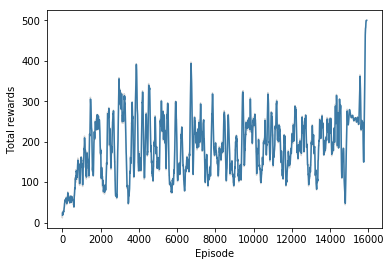

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

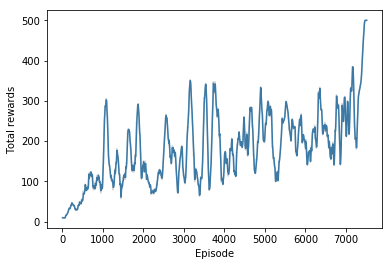

In [29]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

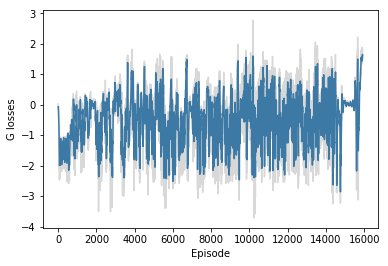

In [31]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

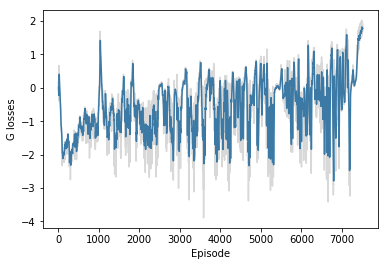

In [30]:
# eps, arr = np.array(g_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('G losses')

Text(0,0.5,'D losses')

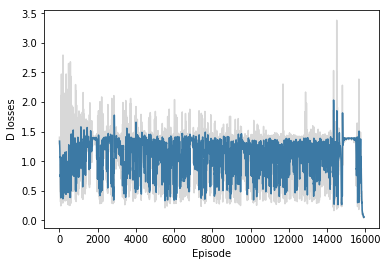

In [32]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

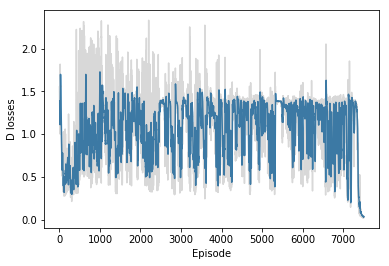

In [31]:
# eps, arr = np.array(d_loss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

Text(0,0.5,'D losses R')

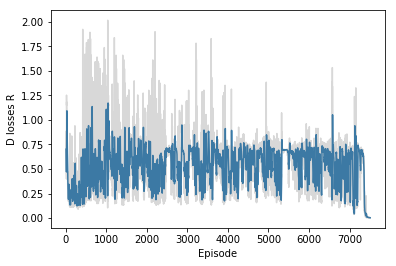

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

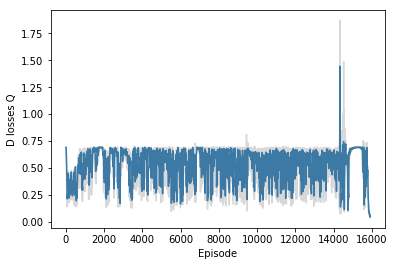

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

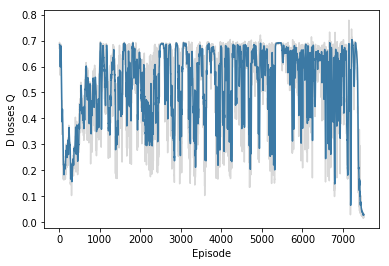

In [33]:
# eps, arr = np.array(d_lossQ_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.